In [1]:

import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import boxcox
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import ttest_rel
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [2]:
from src import utils
from src import validation
from src import base_forecast
from src.utils import print_title

In [66]:
import importlib
importlib.reload(utils)
importlib.reload(validation)
importlib.reload(base_forecast)

<module 'src.base_forecast' from '/Users/jobandtalent/Documents/GitHub/forecast-incremental-workflow/src/base_forecast.py'>

## DATA INGESTION

### LOAD

In [4]:
day_df_raw = pd.read_csv('../data/day.csv')
display(day_df_raw.head())
print('DF Size: ', day_df_raw.shape)
print('DF Types: \n', day_df_raw.dtypes)

df = day_df_raw.copy()

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1        0        6           0   
1        2  2011-01-02       1   0     1        0        0           0   
2        3  2011-01-03       1   0     1        0        1           1   
3        4  2011-01-04       1   0     1        0        2           1   
4        5  2011-01-05       1   0     1        0        3           1   

   weathersit      temp     atemp       hum  windspeed  casual  registered  \
0           2  0.344167  0.363625  0.805833   0.160446     331         654   
1           2  0.363478  0.353739  0.696087   0.248539     131         670   
2           1  0.196364  0.189405  0.437273   0.248309     120        1229   
3           1  0.200000  0.212122  0.590435   0.160296     108        1454   
4           1  0.226957  0.229270  0.436957   0.186900      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600

DF Size:  (731, 16)
DF Types: 
 instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object


### DTYPES

In [5]:
datetime_columns = ['dteday']
float64_columns = ['temp','atemp','hum','windspeed']
str_columns = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
int64_columns = ['casual', 'registered', 'cnt']

# Basic data conversion
df = utils.format_columns(df, datetime_columns, int64_columns, float64_columns, str_columns)
# Rename columns
df.rename(columns={
    'dteday':'date',
    'yr':'year',
    'mnth':'month',
    'weathersit':'weather',
    'temp':'temperature',
    'atemp':'temperature_sensation',
    'hum':'humidity',
    'casual':'casual_users',
    'registered':'registered_users',
    'cnt':'bikes_rented'
}, inplace=True)
# Drop not used columns
df.drop(columns=['instant'], inplace=True)

# Check dtypes
print_title('CONVERTED DATA TYPES')
print(df.dtypes)
display(df.head(5))

------------------- CONVERTED DATA TYPES -------------------
date                     datetime64[ns]
season                           object
year                             object
month                            object
holiday                          object
weekday                          object
workingday                       object
weather                          object
temperature                     float64
temperature_sensation           float64
humidity                        float64
windspeed                       float64
casual_users                      int64
registered_users                  int64
bikes_rented                      int64
dtype: object


date season year month holiday weekday workingday weather  \
0 2011-01-01      1    0     1       0       6          0       2   
1 2011-01-02      1    0     1       0       0          0       2   
2 2011-01-03      1    0     1       0       1          1       1   
3 2011-01-04      1    0     1       0       2          1       1   
4 2011-01-05      1    0     1       0       3          1       1   

   temperature  temperature_sensation  humidity  windspeed  casual_users  \
0     0.344167               0.363625  0.805833   0.160446           331   
1     0.363478               0.353739  0.696087   0.248539           131   
2     0.196364               0.189405  0.437273   0.248309           120   
3     0.200000               0.212122  0.590435   0.160296           108   
4     0.226957               0.229270  0.436957   0.186900            82   

   registered_users  bikes_rented  
0               654           985  
1               670           801  
2              1229          1349  
3              1454          1562  
4              1518          1600

## DATA CLEANING AND QA

### DESCRIBE

In [6]:
# Quick checks on data
print_title('DF INFO')
display(df.info())

print_title('DF DESCRIBE')
display(df.describe())

# Check distribution of variants
print_title('DISTRIBUTIONS')
display(df['season'].value_counts().sort_index())
display(df['year'].value_counts().sort_index())
display(df['month'].value_counts().sort_index())
display(df['holiday'].value_counts().sort_index())
display(df['weekday'].value_counts().sort_index())
display(df['workingday'].value_counts().sort_index())
display(df['weather'].value_counts().sort_index())

------------------------- DF INFO -------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   731 non-null    datetime64[ns]
 1   season                 731 non-null    object        
 2   year                   731 non-null    object        
 3   month                  731 non-null    object        
 4   holiday                731 non-null    object        
 5   weekday                731 non-null    object        
 6   workingday             731 non-null    object        
 7   weather                731 non-null    object        
 8   temperature            731 non-null    float64       
 9   temperature_sensation  731 non-null    float64       
 10  humidity               731 non-null    float64       
 11  windspeed              731 non-null    float64       
 12  casu

None

----------------------- DF DESCRIBE -----------------------


date  temperature  temperature_sensation    humidity  \
count                  731   731.000000             731.000000  731.000000   
mean   2012-01-01 00:00:00     0.495385               0.474354    0.627894   
min    2011-01-01 00:00:00     0.059130               0.079070    0.000000   
25%    2011-07-02 12:00:00     0.337083               0.337842    0.520000   
50%    2012-01-01 00:00:00     0.498333               0.486733    0.626667   
75%    2012-07-01 12:00:00     0.655417               0.608602    0.730209   
max    2012-12-31 00:00:00     0.861667               0.840896    0.972500   
std                    NaN     0.183051               0.162961    0.142429   

        windspeed  casual_users  registered_users  bikes_rented  
count  731.000000    731.000000        731.000000    731.000000  
mean     0.190486    848.176471       3656.172367   4504.348837  
min      0.022392      2.000000         20.000000     22.000000  
25%      0.134950    315.500000       2497.000000   3152.000000  
50%      0.180975    713.000000       3662.000000   4548.000000  
75%      0.233214   1096.000000       4776.500000   5956.000000  
max      0.507463   3410.000000       6946.000000   8714.000000  
std      0.077498    686.622488       1560.256377   1937.211452

---------------------- DISTRIBUTIONS ----------------------


season
1    181
2    184
3    188
4    178
Name: count, dtype: int64

year
0    365
1    366
Name: count, dtype: int64

month
1     62
10    62
11    60
12    62
2     57
3     62
4     60
5     62
6     60
7     62
8     62
9     60
Name: count, dtype: int64

holiday
0    710
1     21
Name: count, dtype: int64

weekday
0    105
1    105
2    104
3    104
4    104
5    104
6    105
Name: count, dtype: int64

workingday
0    231
1    500
Name: count, dtype: int64

weather
1    463
2    247
3     21
Name: count, dtype: int64

### DUPLICATES

In [7]:
# Check for and drop duplicates in the entire DataFrame
duplicated_rows = df.duplicated().sum()
print('# of duplicated rows: ', duplicated_rows)

if duplicated_rows > 0:
    df = df.drop_duplicates()
    print('Duplicates in the DataFrame removed.')
else:
    print('No duplicates in the DataFrame found.')

# of duplicated rows:  0
No duplicates in the DataFrame found.


In [8]:
primary_key_column = 'date'

# Check for duplicates in the unique columns
duplicated_rows = df[df[primary_key_column].duplicated(keep=False)]
print(f'# of duplicated on {primary_key_column} column: {duplicated_rows[primary_key_column].nunique()}')

if not duplicated_rows.empty:
    print(f'Duplicated {primary_key_column} and their rows:')
    display(duplicated_rows.sort_values(by = primary_key_column))

    # Keep only the first following timestamp column order
    if primary_key_column == '':
        df = df.drop_duplicates(subset=primary_key_column, keep='first')
        print('Kept the most recent row for each duplicated' +  primary_key_column)
    else:
        df = df.sort_values(primary_key_column).drop_duplicates(subset=primary_key_column, keep='first')
        print('Kept the most recent row for each duplicated ' + primary_key_column)

# of duplicated on date column: 0


### NULLS

In [9]:
# Check for missing values
missing_values = df.isnull().sum()
print_title('NUMBER OF NULL VALUES')
print(missing_values)

------------------ NUMBER OF NULL VALUES ------------------
date                     0
season                   0
year                     0
month                    0
holiday                  0
weekday                  0
workingday               0
weather                  0
temperature              0
temperature_sensation    0
humidity                 0
windspeed                0
casual_users             0
registered_users         0
bikes_rented             0
dtype: int64


### OUTLIERS

In [10]:
target_columns = ['casual_users', 'registered_users', 'bikes_rented']

numeric_cols = df.drop(columns=target_columns, errors='ignore').select_dtypes(include=["number"])
outliers_df = utils.detect_outliers(numeric_cols, method="iqr")
outlier_rows = df.loc[outliers_df.any(axis=1)]
print_title('ANOMALY ROWS')
display(outliers_df[outliers_df['is_outlier']])

df["extreme_weather"] = outliers_df["is_outlier"].astype(int).astype(str)
display(df.head())

----------------------- ANOMALY ROWS -----------------------


iqr_outlier  zscore_outlier        outlier_columns  is_outlier
44          True           False            [windspeed]        True
49          True           False  [humidity, windspeed]        True
68          True           False             [humidity]        True
93          True           False            [windspeed]        True
94          True           False            [windspeed]        True
292         True           False            [windspeed]        True
382         True           False            [windspeed]        True
407         True           False            [windspeed]        True
420         True           False            [windspeed]        True
432         True           False            [windspeed]        True
433         True           False            [windspeed]        True
450         True           False            [windspeed]        True
666         True           False            [windspeed]        True
721         True           False            [windspeed]        True

date season year month holiday weekday workingday weather  \
0 2011-01-01      1    0     1       0       6          0       2   
1 2011-01-02      1    0     1       0       0          0       2   
2 2011-01-03      1    0     1       0       1          1       1   
3 2011-01-04      1    0     1       0       2          1       1   
4 2011-01-05      1    0     1       0       3          1       1   

   temperature  temperature_sensation  humidity  windspeed  casual_users  \
0     0.344167               0.363625  0.805833   0.160446           331   
1     0.363478               0.353739  0.696087   0.248539           131   
2     0.196364               0.189405  0.437273   0.248309           120   
3     0.200000               0.212122  0.590435   0.160296           108   
4     0.226957               0.229270  0.436957   0.186900            82   

   registered_users  bikes_rented extreme_weather  
0               654           985               0  
1               670           801               0  
2              1229          1349               0  
3              1454          1562               0  
4              1518          1600               0

## EDA

In [11]:
target_column = 'bikes_rented'
eda_df = df.copy()
display(eda_df.head())

date season year month holiday weekday workingday weather  \
0 2011-01-01      1    0     1       0       6          0       2   
1 2011-01-02      1    0     1       0       0          0       2   
2 2011-01-03      1    0     1       0       1          1       1   
3 2011-01-04      1    0     1       0       2          1       1   
4 2011-01-05      1    0     1       0       3          1       1   

   temperature  temperature_sensation  humidity  windspeed  casual_users  \
0     0.344167               0.363625  0.805833   0.160446           331   
1     0.363478               0.353739  0.696087   0.248539           131   
2     0.196364               0.189405  0.437273   0.248309           120   
3     0.200000               0.212122  0.590435   0.160296           108   
4     0.226957               0.229270  0.436957   0.186900            82   

   registered_users  bikes_rented extreme_weather  
0               654           985               0  
1               670           801               0  
2              1229          1349               0  
3              1454          1562               0  
4              1518          1600               0

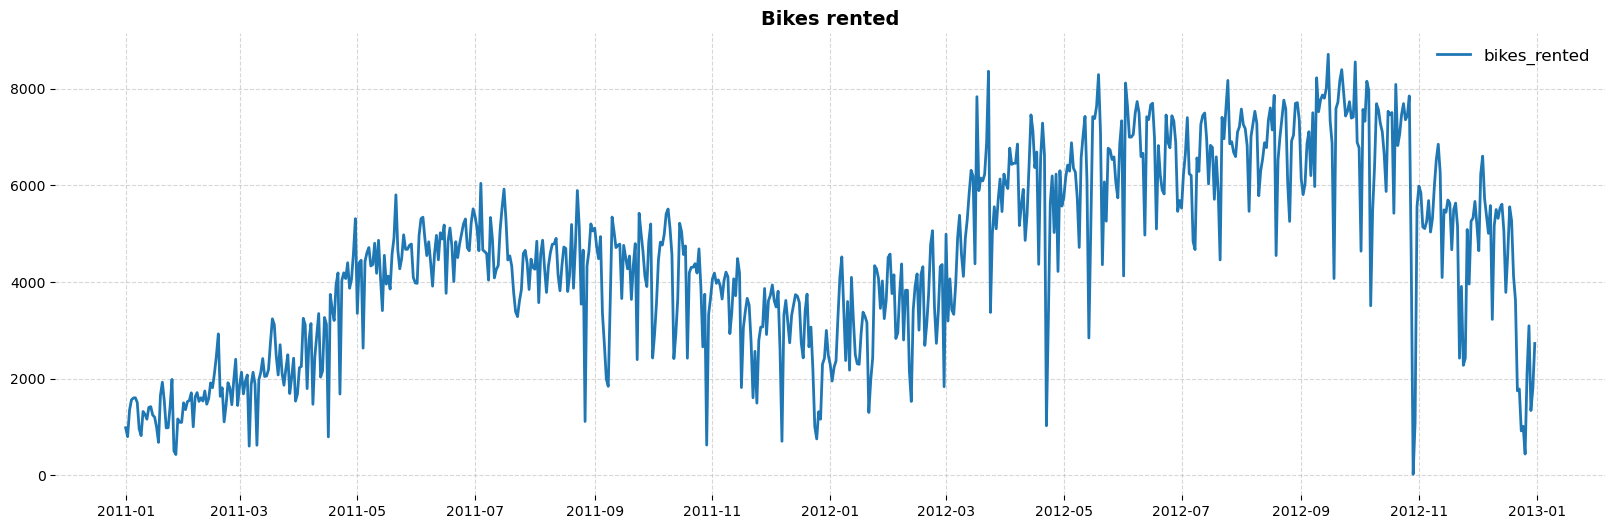

In [12]:
utils.plot_time_series(eda_df, [target_column], 0.9, '--')

### STATIONARITY

In [13]:

stationary_result = adfuller(eda_df["bikes_rented"])
is_stationary_resultt = True if stationary_result[1] < 0.05 else False
print(f"ADF Statistic: {stationary_result[0]}")
print(f"P-value: {stationary_result[1]}")
print("Conclusion:", "Stationary" if stationary_result[1] < 0.05 else "Non-stationary")

ADF Statistic: -1.8774481444374296
P-value: 0.34274344033921944
Conclusion: Non-stationary


### TREND

In [14]:

trend_result = kpss(eda_df["bikes_rented"], regression="c")
is_trend_present = True if trend_result[1] < 0.05 else False
print(f"KPSS Statistic: {trend_result[0]}")
print(f"P-value: {trend_result[1]}")
print("Conclusion:", "Trend present" if trend_result[1] < 0.05 else "No significant trend")

KPSS Statistic: 2.424033427910016
P-value: 0.01
Conclusion: Trend present


### TIME PERSISTENCE AND SEASONALITY

In [15]:
nlags = 365
acf_values = acf(eda_df["bikes_rented"], nlags=nlags, fft=True)

autocorrelated_lags = np.where(np.abs(acf_values) > 0.5)[0]
autocorrelation_ratio = len(autocorrelated_lags) / nlags

seasonal_lags = [lag for lag in autocorrelated_lags if lag % 7 == 0 or lag % 30 == 0 or lag % 365 == 0]

print(f"Lags with autocorrelation: {autocorrelated_lags.tolist()}")
print(f"Percentage of significant lags: {autocorrelation_ratio:.2%}")
print(f"Possible seasonal lags: {seasonal_lags}")

if autocorrelation_ratio > 0.5:
    print("Strong temporal dependence detected.")
elif autocorrelation_ratio > 0.3:
    print("Moderate temporal dependence detected.")
else:
    print("Low temporal dependence.")

if len(seasonal_lags) > 2:
    is_seasonality_present = True
    print("Seasonality detected.")
else:
    is_seasonality_present = False
    print("No clear seasonality.")

Lags with autocorrelation: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51]
Percentage of significant lags: 13.97%
Possible seasonal lags: [0, 7, 14, 21, 28, 30, 35, 42, 49]
Low temporal dependence.
Seasonality detected.


### ACF AND PACF

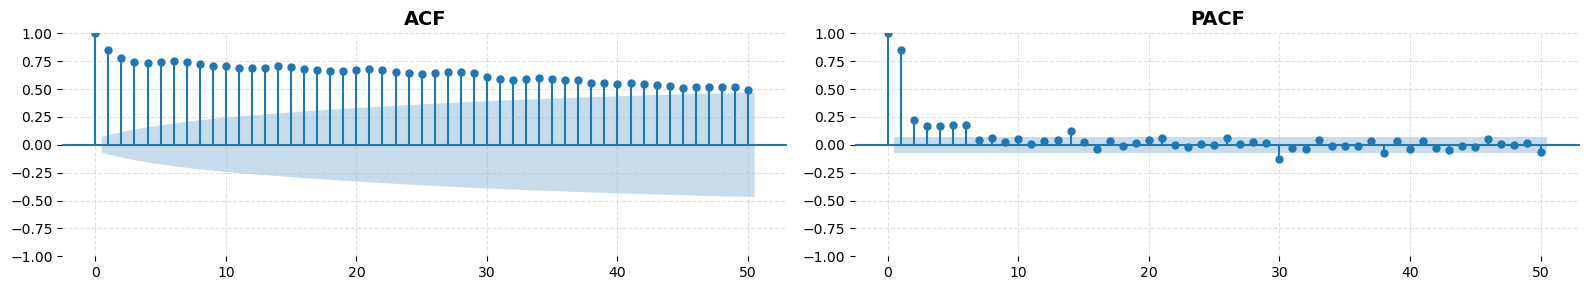

In [16]:
utils.plot_acf_and_pacf(eda_df[target_column])

### DECOMPOSITION

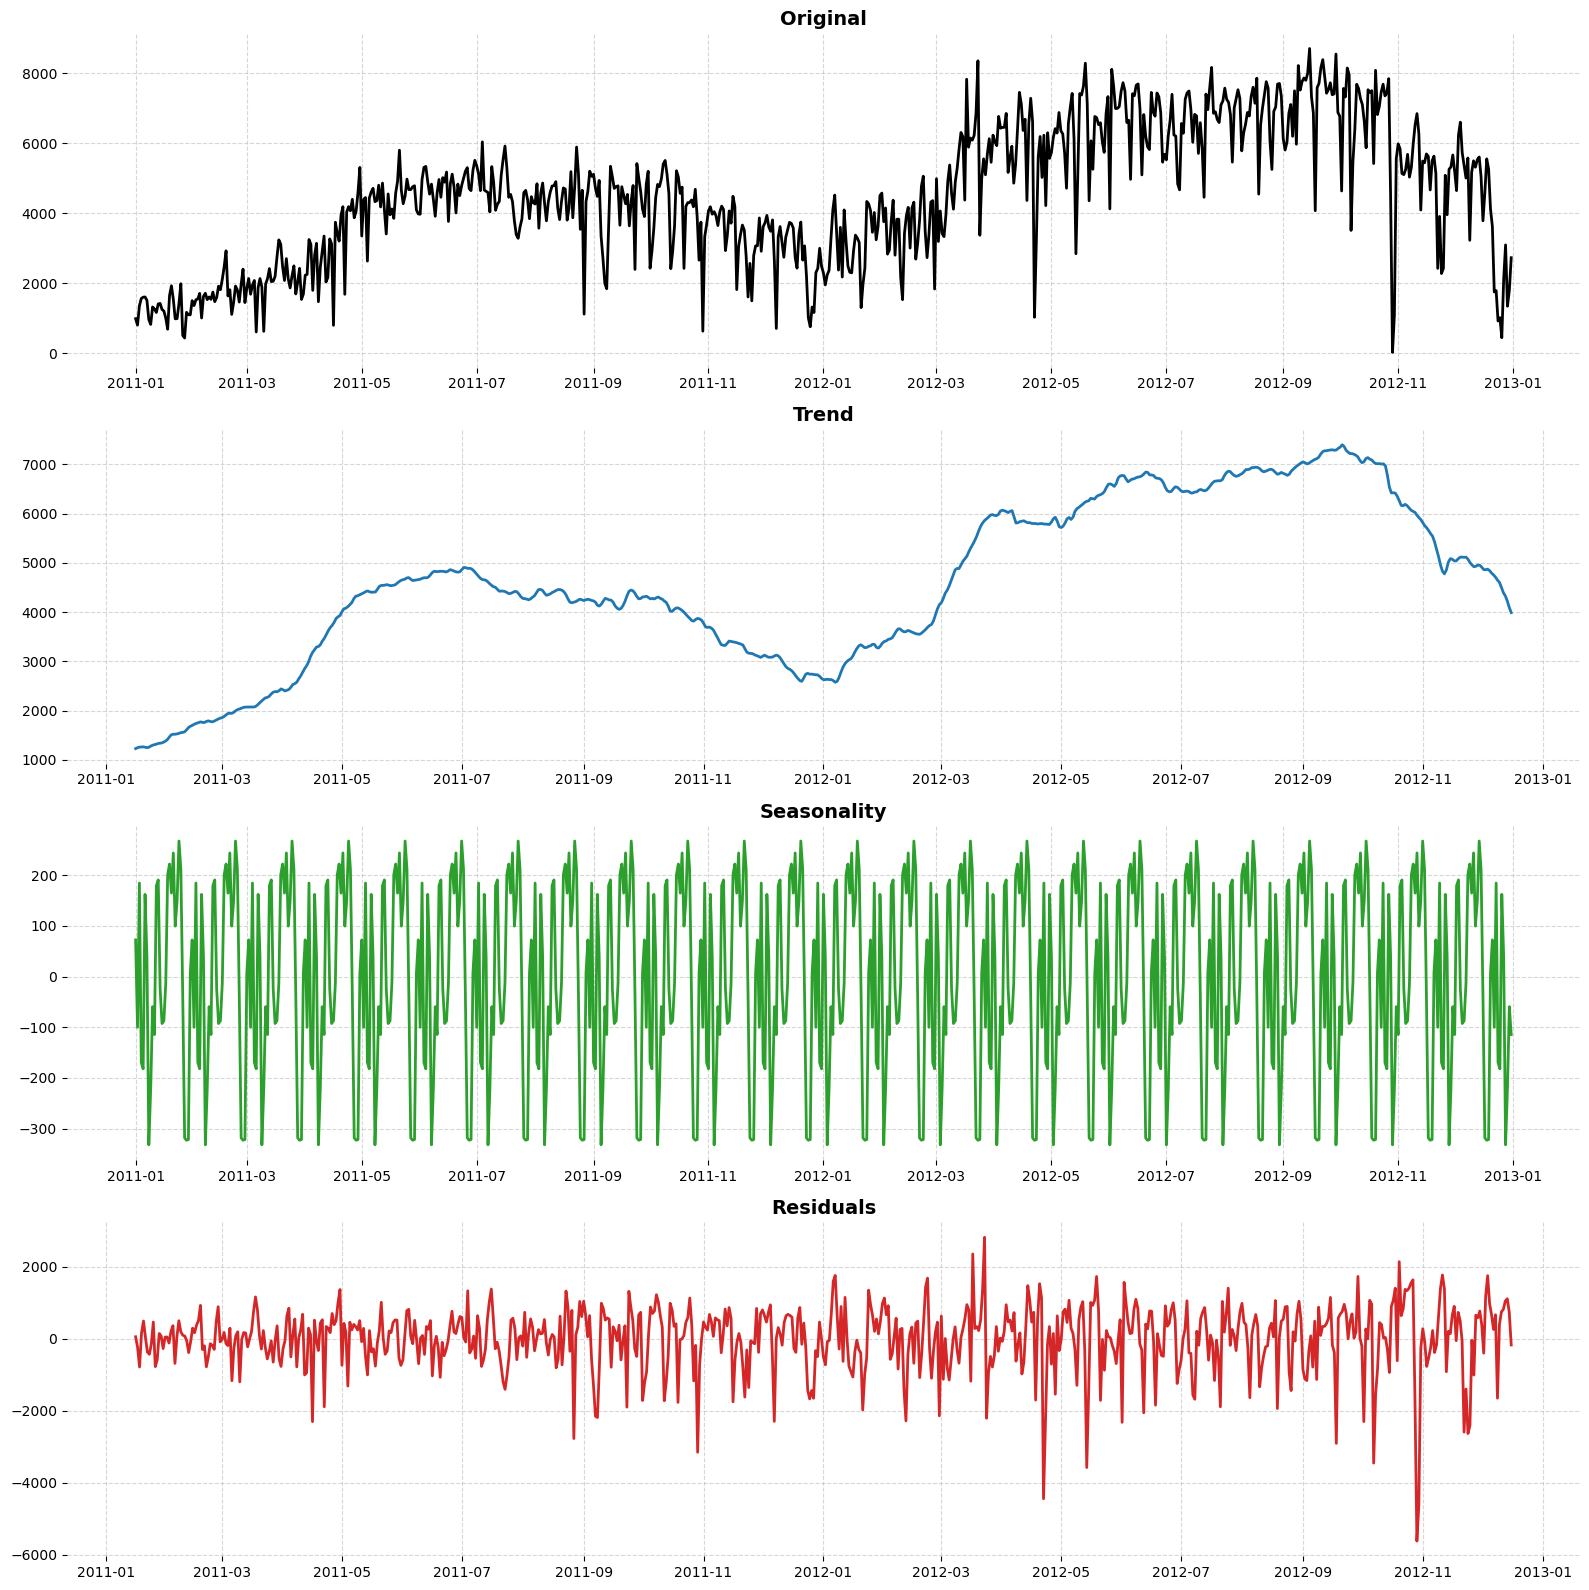

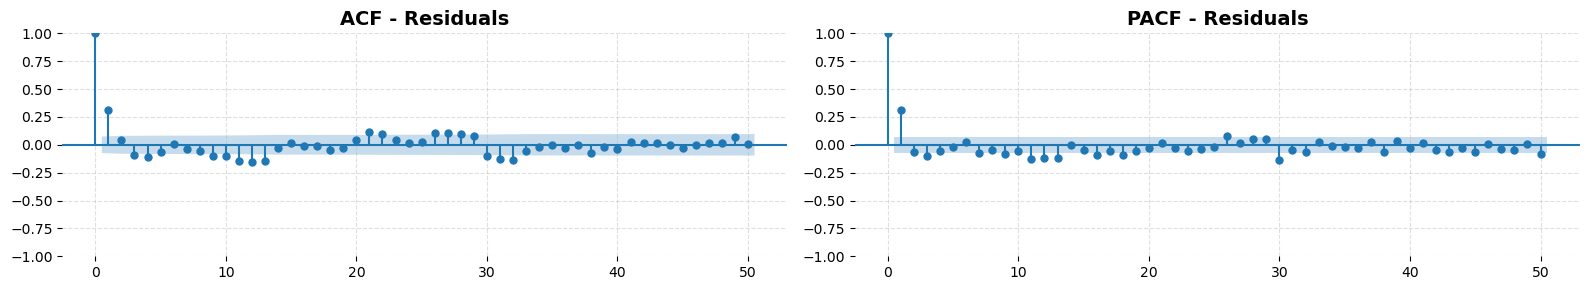

In [17]:
decomposed = seasonal_decompose(eda_df[target_column], model='additive', period=30)

fig, axes = plt.subplots(4, 1, figsize=(16, 16))

axes[0].plot(eda_df["date"], decomposed.observed, color="black", linewidth=2)
axes[0].set_title("Original", fontsize=14, fontweight='bold')

axes[1].plot(eda_df["date"], decomposed.trend, color="tab:blue", linewidth=2)
axes[1].set_title("Trend", fontsize=14, fontweight='bold')

axes[2].plot(eda_df["date"], decomposed.seasonal, color="tab:green", linewidth=2)
axes[2].set_title("Seasonality", fontsize=14, fontweight='bold')

axes[3].plot(eda_df["date"], decomposed.resid, color="tab:red", linewidth=2)
axes[3].set_title("Residuals", fontsize=14, fontweight='bold')

for ax in axes:
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.tick_params(axis='x', rotation=0, labelsize=10)

plt.tight_layout()
plt.show()

utils.plot_acf_and_pacf(decomposed.resid.dropna(), ' - Residuals')

### OUTLIERS

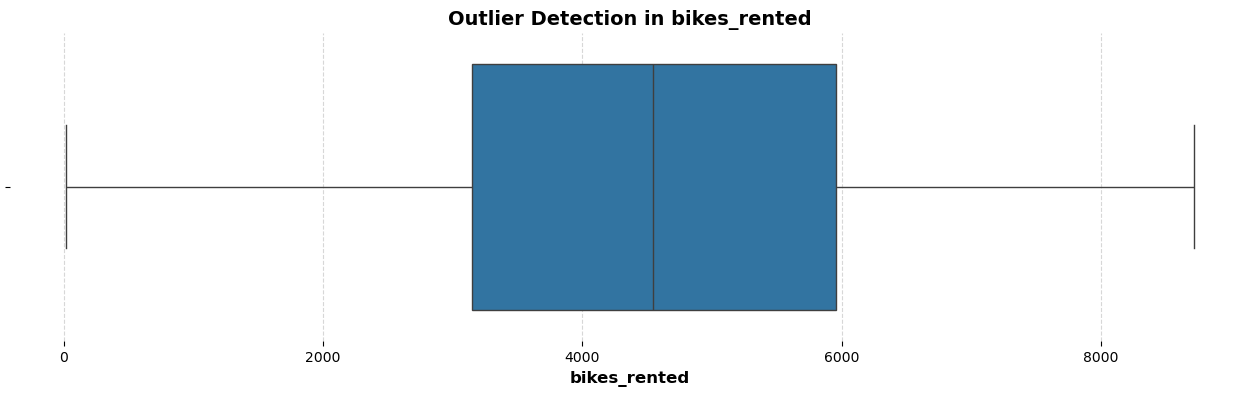

In [18]:
fig, ax = plt.subplots(figsize=(16,4))

sns.boxplot(
    x=df[target_column], 
    ax=ax, 
    flierprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "black", "markersize": 6}
)

ax.set_title(f"Outlier Detection in {target_column}", fontsize=14, fontweight="bold")
ax.set_xlabel(target_column, fontsize=12, fontweight="bold")

for spine in ax.spines.values():
    spine.set_visible(False)

ax.grid(axis="x", linestyle="--", alpha=0.5)

plt.show()

## UNIVARIANT FORECASTING

#### TIME NORMALIZATION

In [19]:
use_time_normalization = False
selection_df = eda_df.copy()
target_time_norm_column = target_column + "_time_norm"

if use_time_normalization:
    forecast_column = target_time_norm_column
    selection_df[forecast_column] = eda_df[target_column] / eda_df["date"].dt.days_in_month
    try:
        selection_df.drop(columns=target_column, inplace=True)
    except:
        pass
else:
    forecast_column = target_column
    try:
        selection_df.drop(columns=target_time_norm_column, inplace=True)
    except:
        pass

print('Forecast variable: ', forecast_column)
display(selection_df.head(1))

Forecast variable:  bikes_rented


date season year month holiday weekday workingday weather  \
0 2011-01-01      1    0     1       0       6          0       2   

   temperature  temperature_sensation  humidity  windspeed  casual_users  \
0     0.344167               0.363625  0.805833   0.160446           331   

   registered_users  bikes_rented extreme_weather  
0               654           985               0

#### TRANSFORMATIONS

In [20]:
selection_df = selection_df[['date'] + [forecast_column]]

print_title('Recommended Transformations')
transformations = utils.check_transformations(selection_df)

print('\n')
print_title('DF Prepared')
transformed_df = utils.apply_transformations(selection_df, transformations)
print('Forecast variable: ', forecast_column)

--------------- Recommended Transformations ---------------
             stationary recommended_transformation
bikes_rented      False                     boxcox


----------------------- DF Prepared -----------------------
Transformations applied successfully.


date  bikes_rented
0 2011-01-01    499.329506
1 2011-01-02    415.834439
2 2011-01-03    659.495676
3 2011-01-04    750.805907
4 2011-01-05    766.938328

Forecast variable:  bikes_rented


### BASELINE AND VALIDATION

#### BASELINE

In [21]:
naive_forecast_df = base_forecast.naive_forecast(transformed_df, forecast_column, steps=60)
baseline_column = 'naive_forecast'

#### VALIDATION

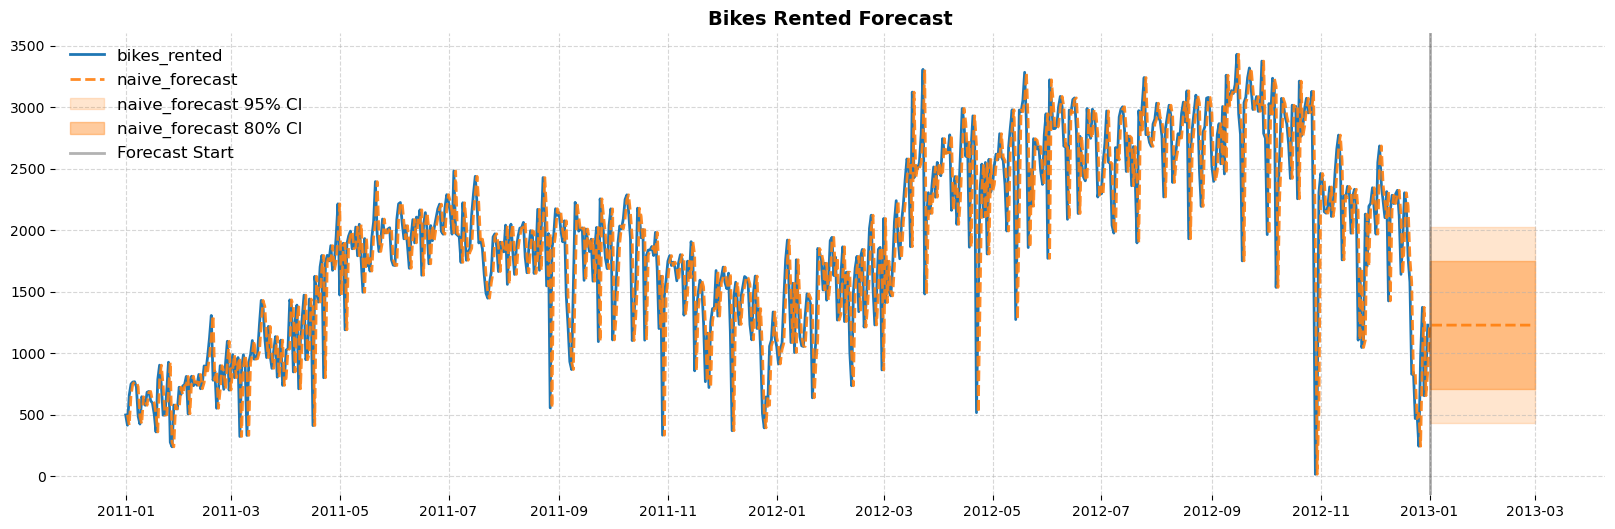

In [22]:
validation.plot_time_series_forecast(naive_forecast_df, [forecast_column, 'naive_forecast'])

##### METRICS

In [23]:
model_metrics = validation.calculate_forecast_metrics(naive_forecast_df, naive_forecast_df, forecast_column, "naive_forecast")
print(model_metrics)

{'MAE': 278.5863254953301, 'RMSE': 407.23722669057526, 'SMAPE': 18.142430243257664, 'MASE': 1.0}


##### TIME VALIDATION

In [24]:
# Walk-Forward Validation
walk_results = validation.walk_forward_validation(naive_forecast_df, naive_forecast_df, "bikes_rented", "naive_forecast", steps=30, n_splits=5)

# Expanding Window Validation
expanding_results = validation.expanding_window_validation(naive_forecast_df, naive_forecast_df, "bikes_rented", "naive_forecast", steps=30, initial_train_size=100)

# Rolling Window Validation
rolling_results = validation.rolling_window_validation(naive_forecast_df, naive_forecast_df, "bikes_rented", "naive_forecast", steps=30, window_size=100)

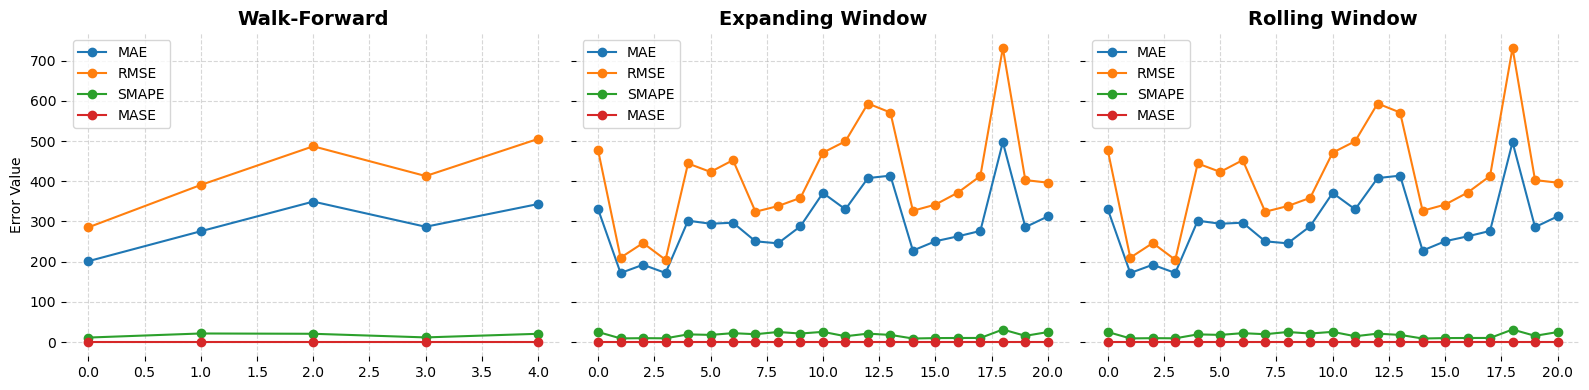

In [25]:
validation.plot_validation_results(walk_results, expanding_results, rolling_results)

##### RESIDUALS

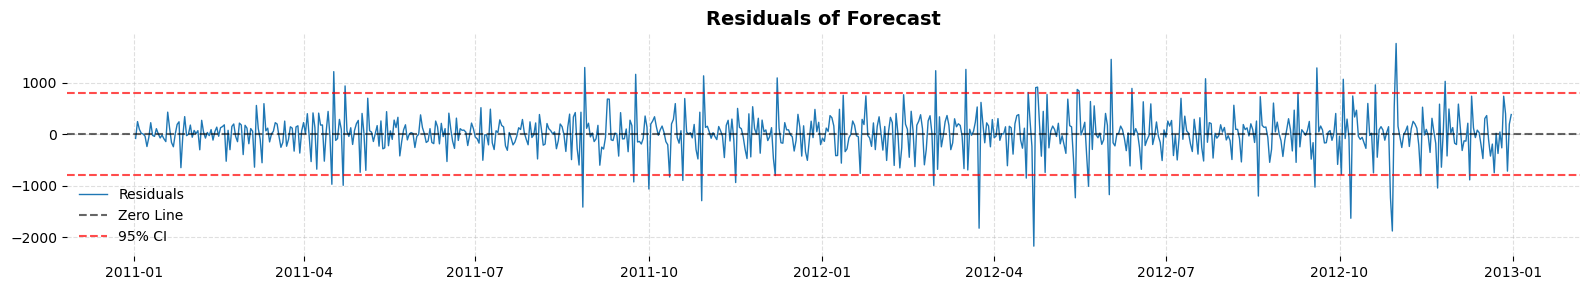

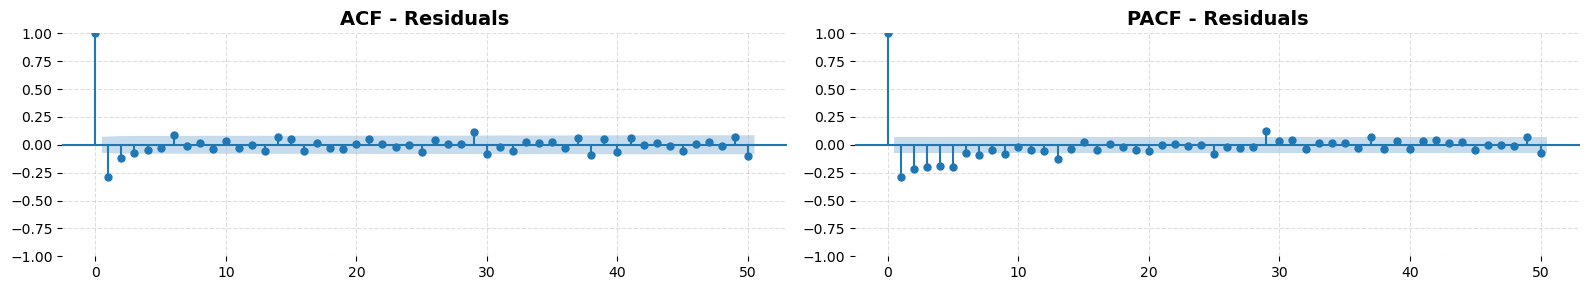

In [26]:
validation.check_forecast_residuals(naive_forecast_df, "bikes_rented", "naive_forecast")


#### BASELINE COMPARISON

In [27]:
comparison_results = validation.compare_forecast_models(naive_forecast_df, naive_forecast_df, naive_forecast_df, forecast_column, "naive_forecast")
formatted_results_df = validation.format_comparison_results(comparison_results)
display(formatted_results_df)

Model    Baseline      Improvement
MAE                       278.586325  278.586325              0.0
RMSE                      407.237227  407.237227              0.0
SMAPE                       18.14243    18.14243              0.0
MASE                             1.0         1.0              0.0
DM Test p-value                                               nan
Statistical Significance                          Not Significant

#### TEST VALIDATION

---------------- TEST TEMPORAL BACKTESTING ----------------


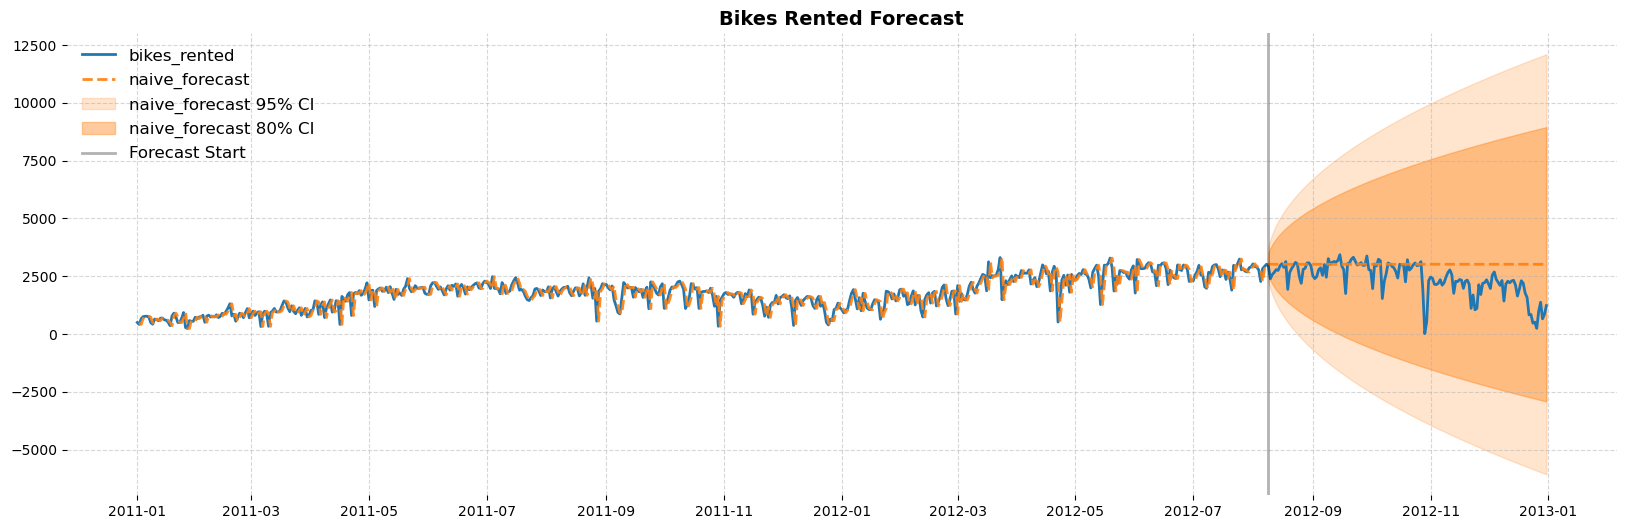

Model    Baseline      Improvement
MAE                       265.528583  265.528583              0.0
RMSE                      384.762166  384.762166              0.0
SMAPE                      17.992191   17.992191              0.0
MASE                             1.0         1.0              0.0
DM Test p-value                                               nan
Statistical Significance                          Not Significant

In [28]:
n_test = 145
naive_forecast_test_df = transformed_df.merge(base_forecast.naive_forecast(transformed_df[:-n_test], forecast_column, steps=n_test)[['date','naive_forecast','is_future_forecast']], on = 'date', how = 'inner')
naive_forecast_test_metrics, naive_forecast_test_comparison_results = validation.test_forecast(naive_df=naive_forecast_test_df, forecast_df=naive_forecast_test_df, baseline_df=naive_forecast_test_df, to_forecast_column = forecast_column, forecasted_column = 'naive_forecast')

### BASE FORECASTING

#### RANDOM WALK

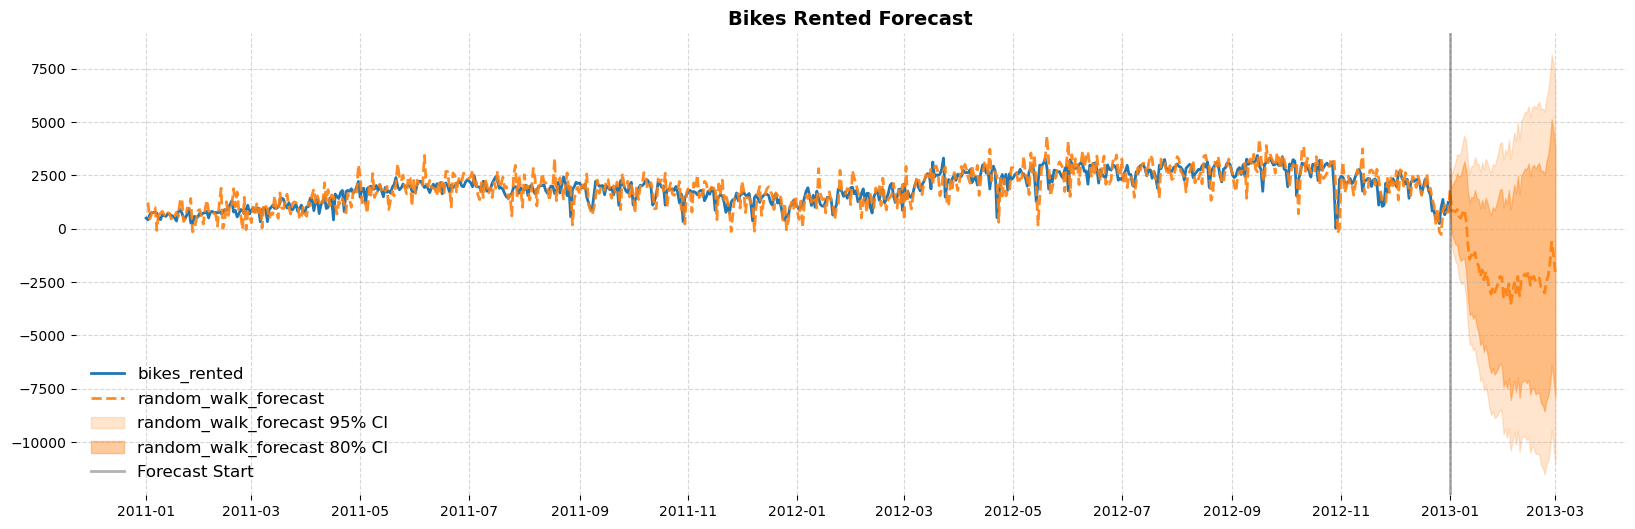

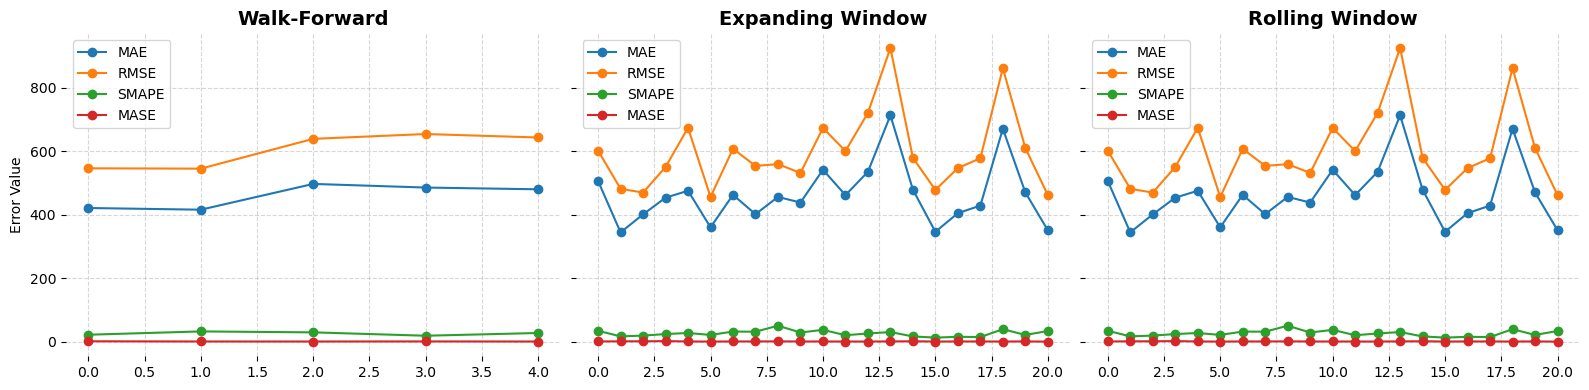

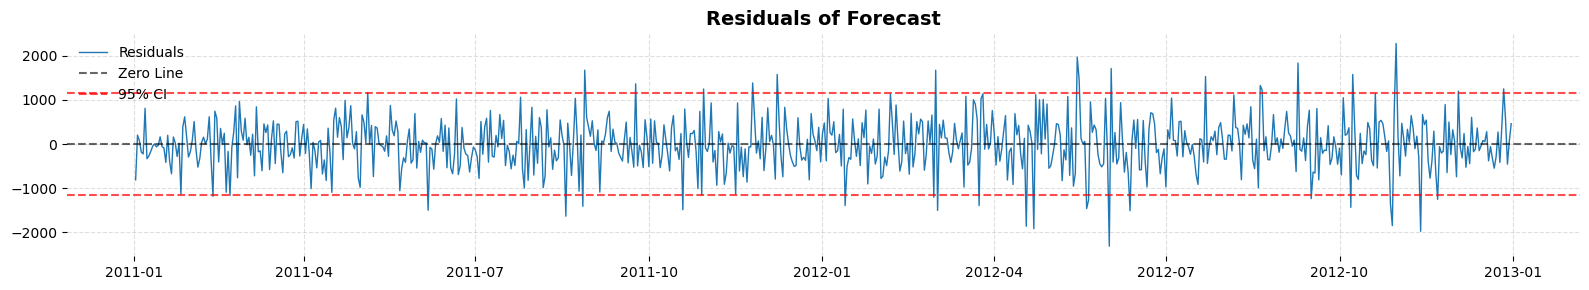

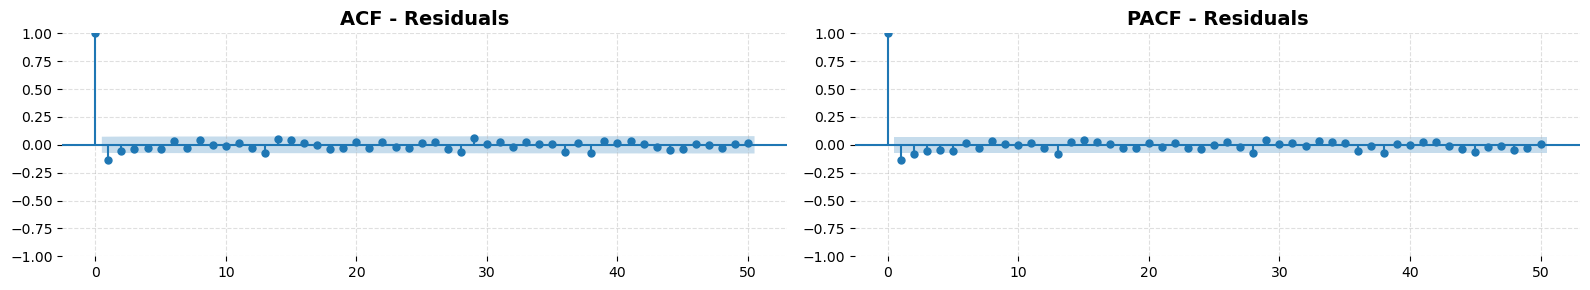

Model    Baseline             Improvement
MAE                       447.117852  278.586325              -60.495262
RMSE                      589.317922  407.237227              -44.711211
SMAPE                       30.10846    18.14243              -65.956048
MASE                        1.604953         1.0              -60.495262
DM Test p-value                                   2.1328179025221636e-40
Statistical Significance                                     Significant

---------------- TEST TEMPORAL BACKTESTING ----------------


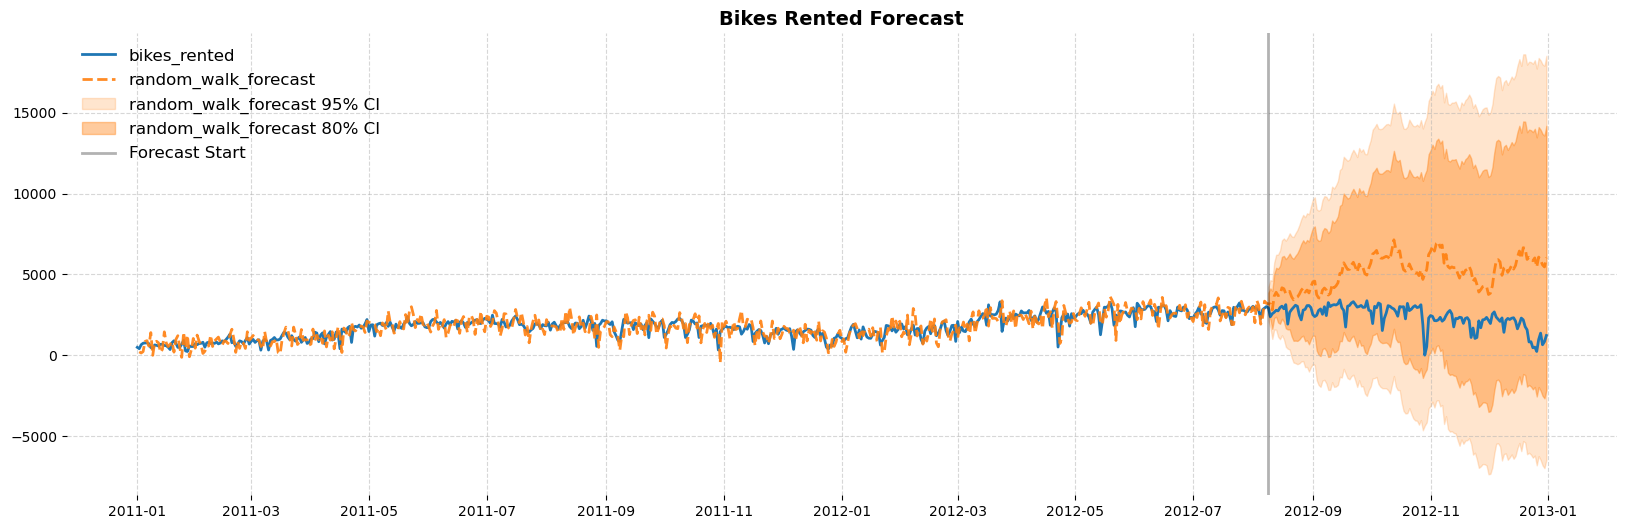

Model    Baseline            Improvement
MAE                       408.966665  265.528583             -54.019828
RMSE                      527.962187  384.762166             -37.217802
SMAPE                      29.047591   17.992191             -61.445551
MASE                        1.540198         1.0             -54.019828
DM Test p-value                                   6.396148491781242e-29
Statistical Significance                                    Significant

In [29]:
# Forecast
random_walk_drift = True if is_trend_present else False
random_walk_forecast_df = base_forecast.random_walk_forecast(transformed_df, forecast_column, steps=60, drift=random_walk_drift)

# Calculate metrics
random_walk_forecast_metrics, random_walk_forecast_comparison_results = validation.validate_forecast(naive_df=naive_forecast_df, forecast_df=random_walk_forecast_df, baseline_df=naive_forecast_df, to_forecast_column = forecast_column, forecasted_column = 'random_walk_forecast')

# Test
n_test = 145
naive_forecast_test_df = base_forecast.naive_forecast(transformed_df[:-n_test], forecast_column, steps=n_test)
random_walk_forecast_test_df = transformed_df.merge(base_forecast.random_walk_forecast(transformed_df[:-n_test], forecast_column, steps=n_test, drift=random_walk_drift)[['date','random_walk_forecast','is_future_forecast']], on = 'date', how = 'inner')
random_walk_forecast_test_metrics, random_walk_forecast_test_comparison_results = validation.test_forecast(naive_df=naive_forecast_test_df, forecast_df=random_walk_forecast_test_df, baseline_df=naive_forecast_test_df, to_forecast_column = forecast_column, forecasted_column = 'random_walk_forecast')

#### EXPONENTIAL SMOOTHING

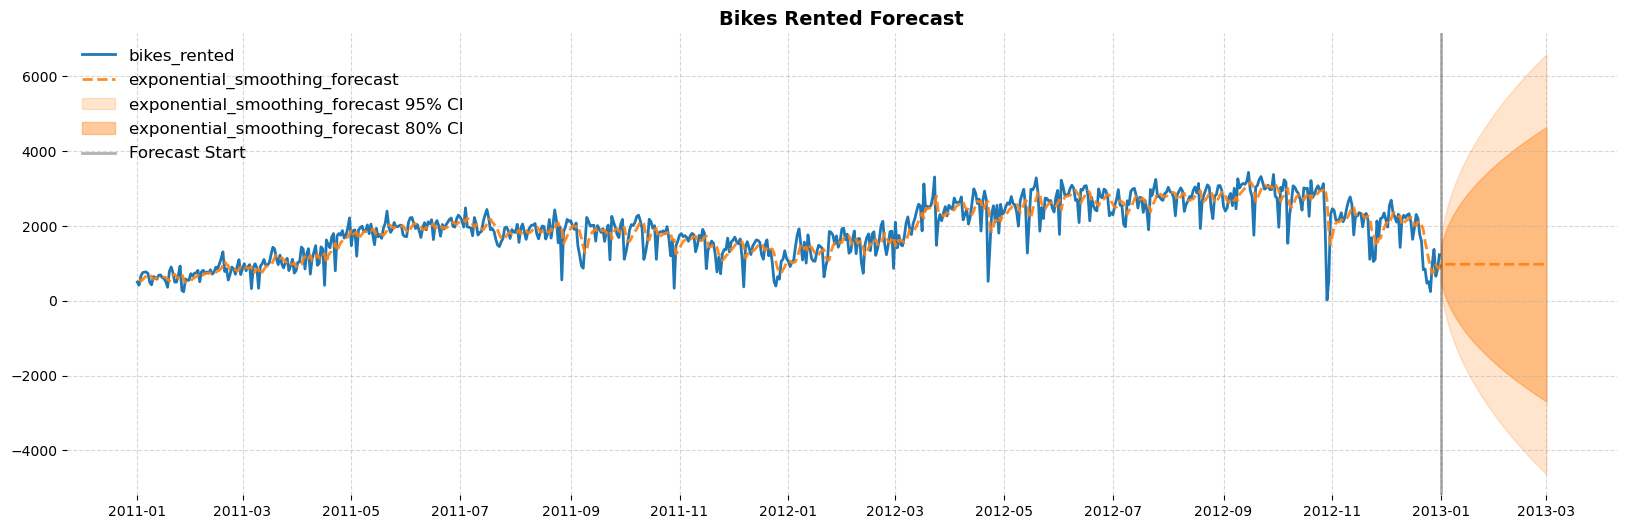

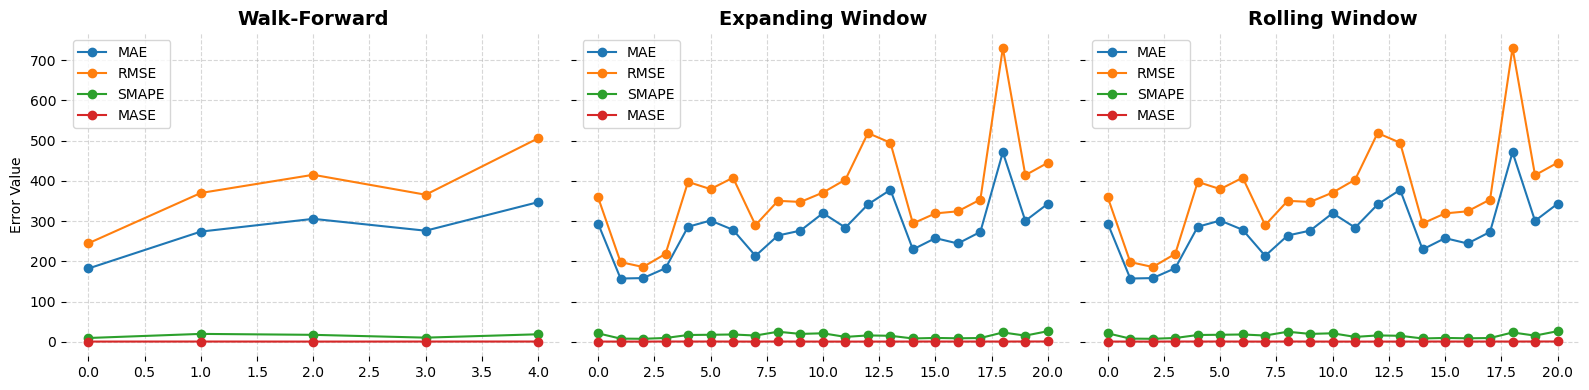

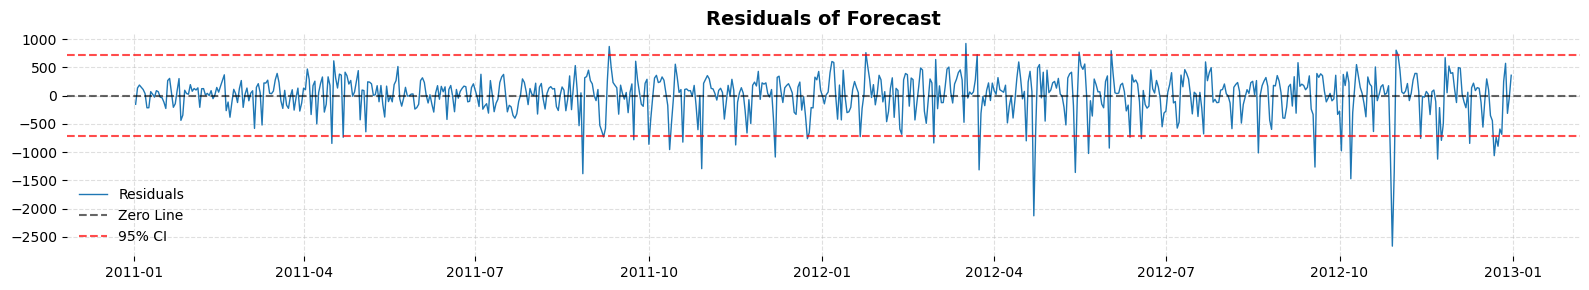

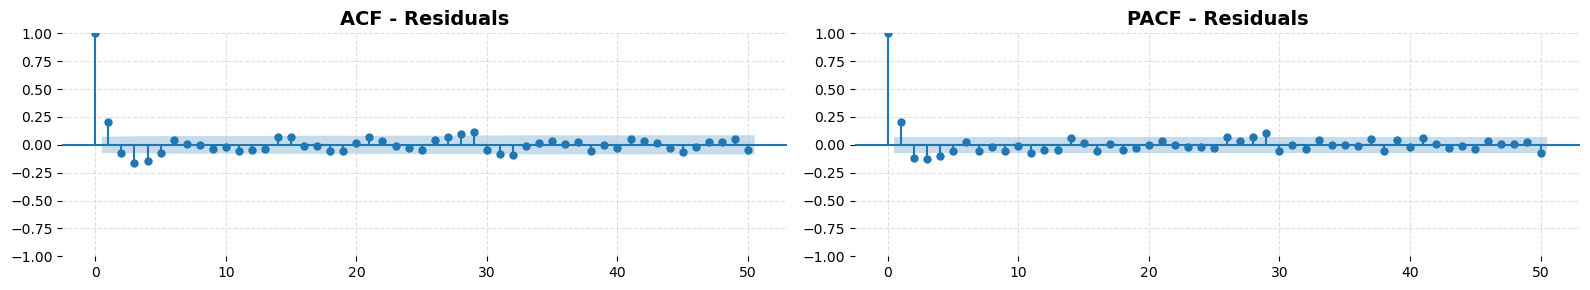

Model    Baseline           Improvement
MAE                       263.311504  278.586325              5.482976
RMSE                      369.551552  407.237227              9.253986
SMAPE                      16.465381    18.14243              9.243794
MASE                         0.94517         1.0              5.482976
DM Test p-value                                   0.057198722306048895
Statistical Significance                               Not Significant

---------------- TEST TEMPORAL BACKTESTING ----------------


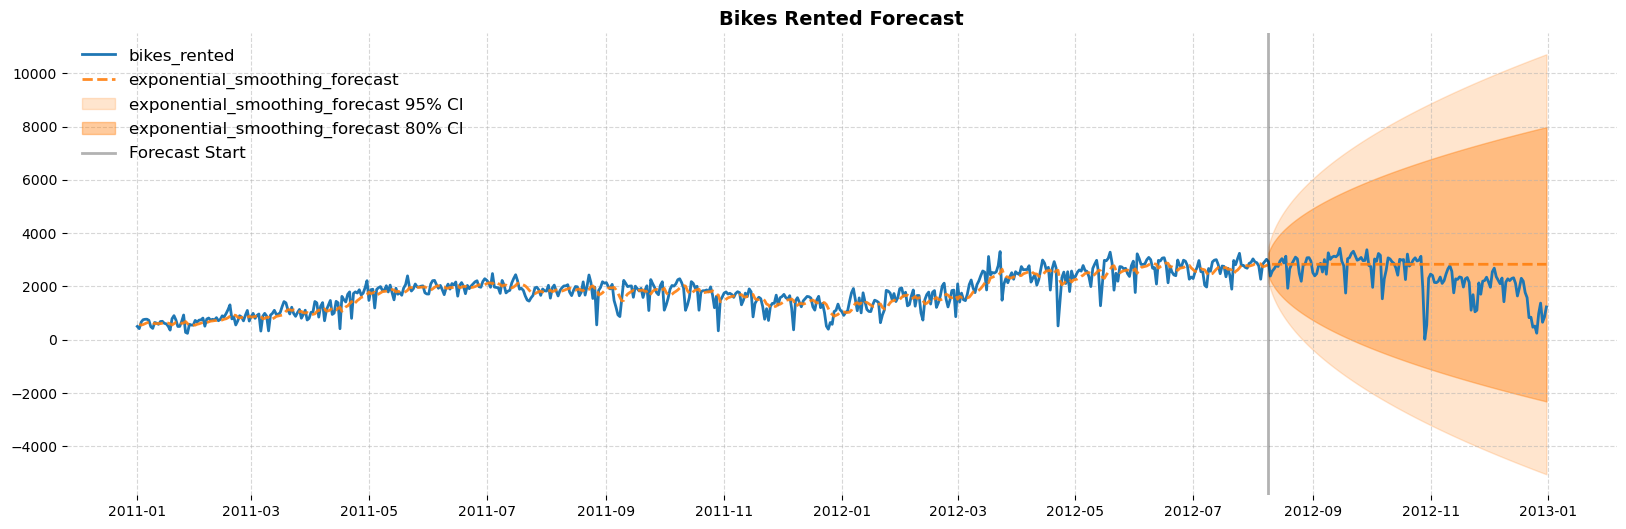

Model    Baseline           Improvement
MAE                       247.686336  265.528583               6.71952
RMSE                      334.313083  384.762166             13.111758
SMAPE                      16.240773   17.992191              9.734321
MASE                        0.932805         1.0               6.71952
DM Test p-value                                   0.052998951961306336
Statistical Significance                               Not Significant

In [30]:
# Forecast
exponential_smoothing_forecast_df = base_forecast.exponential_smoothing_forecast(transformed_df, forecast_column, steps=60)

# Calculate metrics
exponential_smoothing_forecast_metrics, exponential_smoothing_forecast_comparison_results = validation.validate_forecast(naive_df=naive_forecast_df, forecast_df=exponential_smoothing_forecast_df, baseline_df=naive_forecast_df, to_forecast_column = forecast_column, forecasted_column = 'exponential_smoothing_forecast')

# Test
n_test = 145
naive_forecast_test_df = base_forecast.naive_forecast(transformed_df[:-n_test], forecast_column, steps=n_test)
exponential_smoothing_forecast_test_df = transformed_df.merge(base_forecast.exponential_smoothing_forecast(transformed_df[:-n_test], forecast_column, steps=n_test)[['date','exponential_smoothing_forecast','is_future_forecast']], on = 'date', how = 'inner')
exponential_smoothing_forecast_test_metrics, exponential_smoothing_forecast_comparison_test_results = validation.test_forecast(naive_df=naive_forecast_test_df, forecast_df=exponential_smoothing_forecast_test_df, baseline_df=naive_forecast_test_df, to_forecast_column = forecast_column, forecasted_column = 'exponential_smoothing_forecast')

#### HOLT

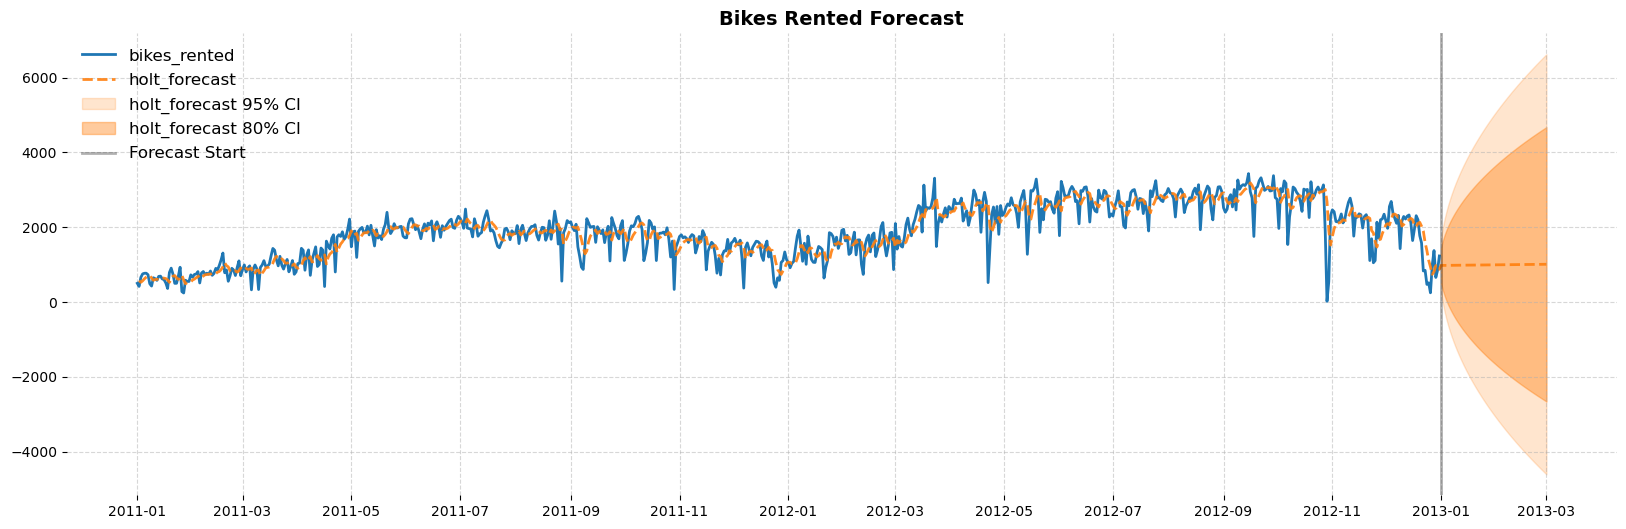

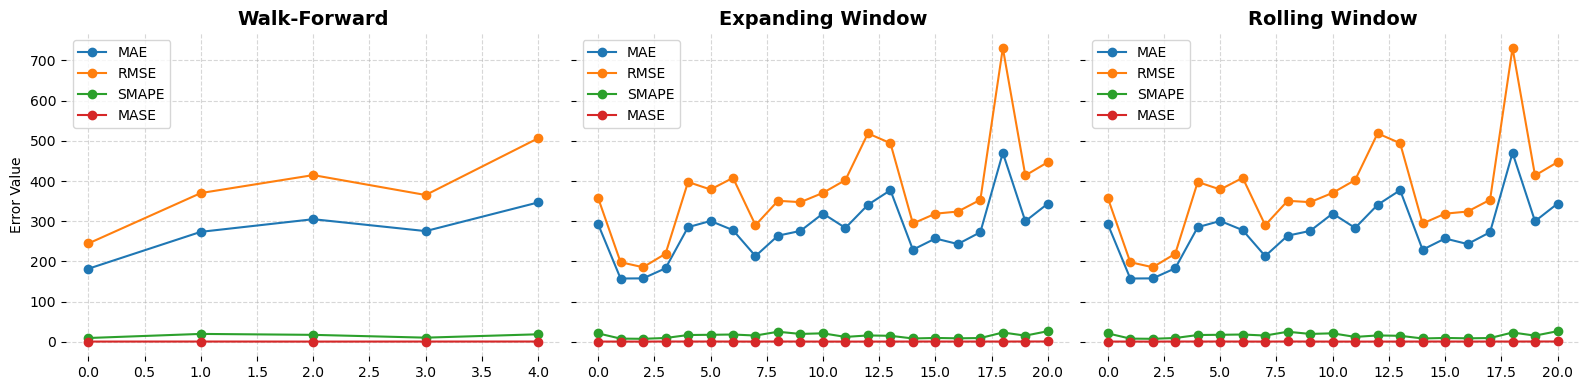

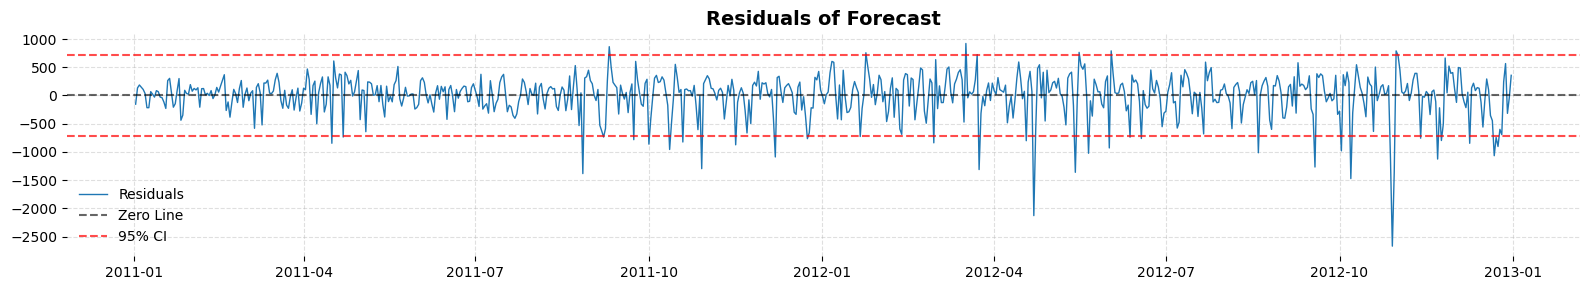

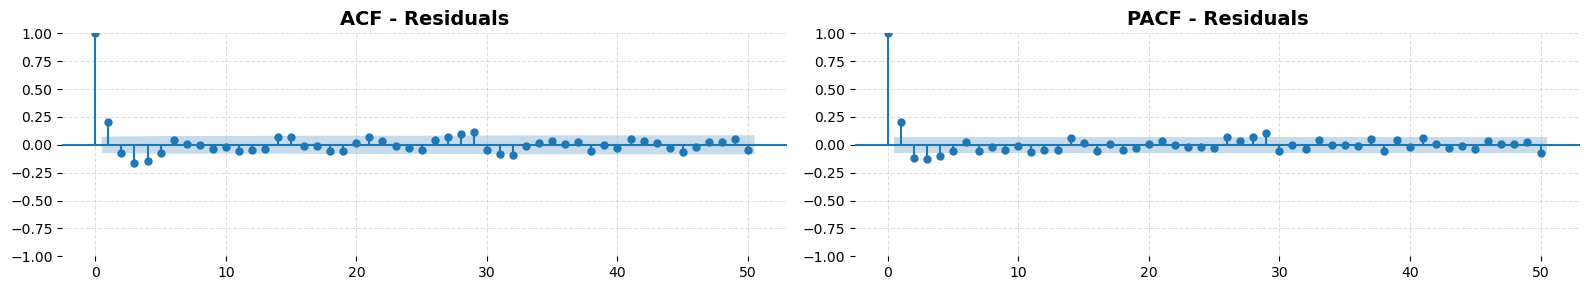

Model    Baseline          Improvement
MAE                       262.832603  278.586325              5.65488
RMSE                      369.569043  407.237227             9.249691
SMAPE                      16.428773    18.14243             9.445579
MASE                        0.943451         1.0              5.65488
DM Test p-value                                   0.05070864989343877
Statistical Significance                              Not Significant

---------------- TEST TEMPORAL BACKTESTING ----------------


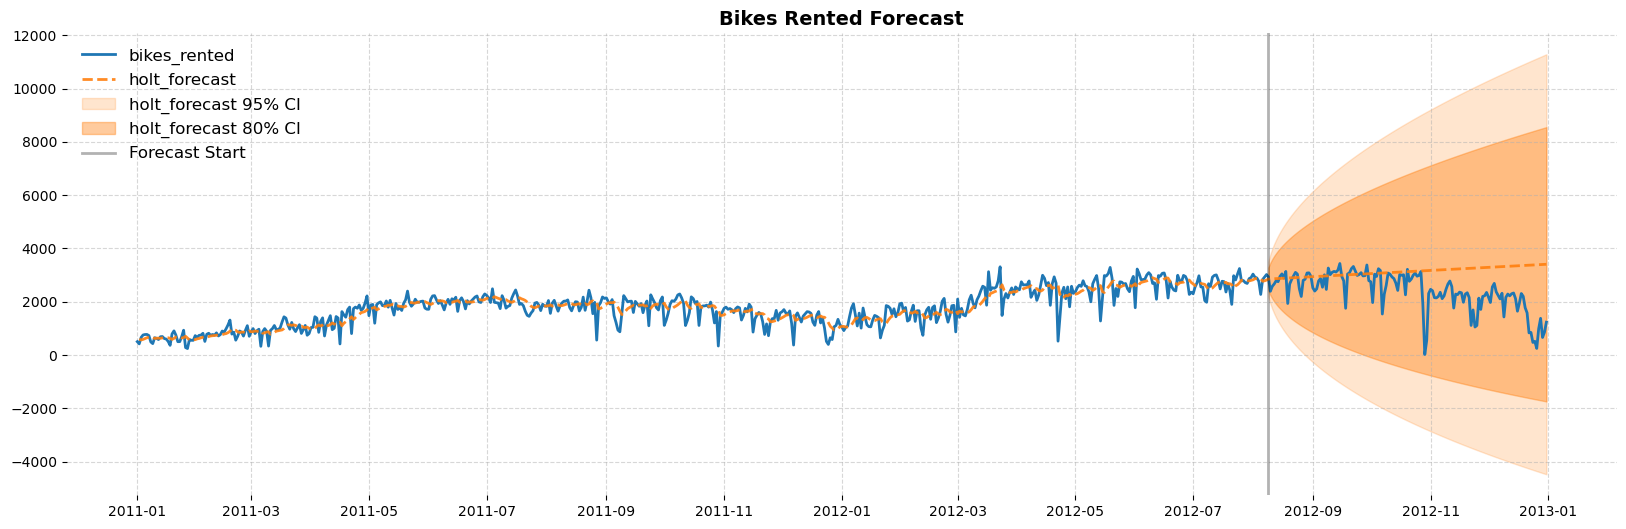

Model    Baseline           Improvement
MAE                       242.812097  265.528583              8.555194
RMSE                      333.726682  384.762166             13.264164
SMAPE                      15.860054   17.992191             11.850347
MASE                        0.914448         1.0              8.555194
DM Test p-value                                   0.015507332076755167
Statistical Significance                                   Significant

In [31]:
# Forecast
holt_forecast_df = base_forecast.holt_forecast(transformed_df, forecast_column, steps=60)

# Calculate metrics
holt_forecast_metrics, holt_forecast_comparison_results = validation.validate_forecast(naive_df=naive_forecast_df, forecast_df=holt_forecast_df, baseline_df=naive_forecast_df, to_forecast_column = forecast_column, forecasted_column = 'holt_forecast')

# Test
n_test = 145
naive_forecast_test_df = base_forecast.naive_forecast(transformed_df[:-n_test], forecast_column, steps=n_test)
holt_forecast_test_df = transformed_df.merge(base_forecast.holt_forecast(transformed_df[:-n_test], forecast_column, steps=n_test)[['date','holt_forecast','is_future_forecast']], on = 'date', how = 'inner')
holt_forecast_test_metrics, holt_forecast_test_comparison_results = validation.test_forecast(naive_df=naive_forecast_test_df, forecast_df=holt_forecast_test_df, baseline_df=naive_forecast_test_df, to_forecast_column = forecast_column, forecasted_column = 'holt_forecast')

#### HOLT-WINTERS

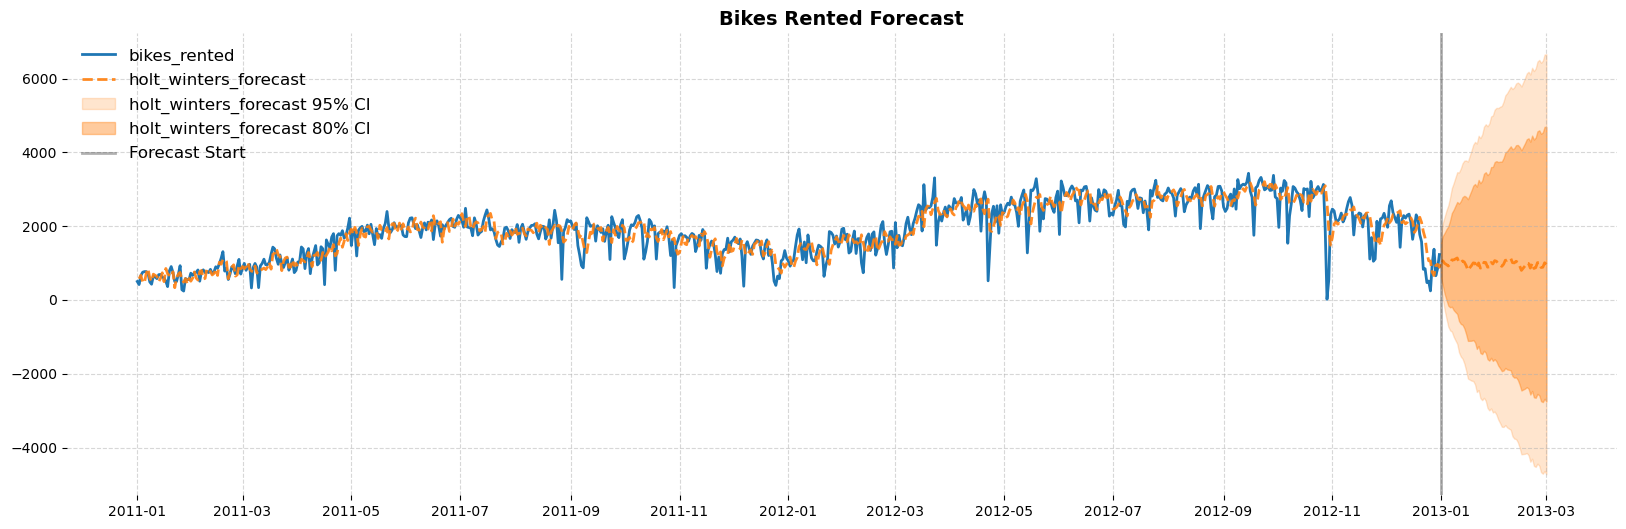

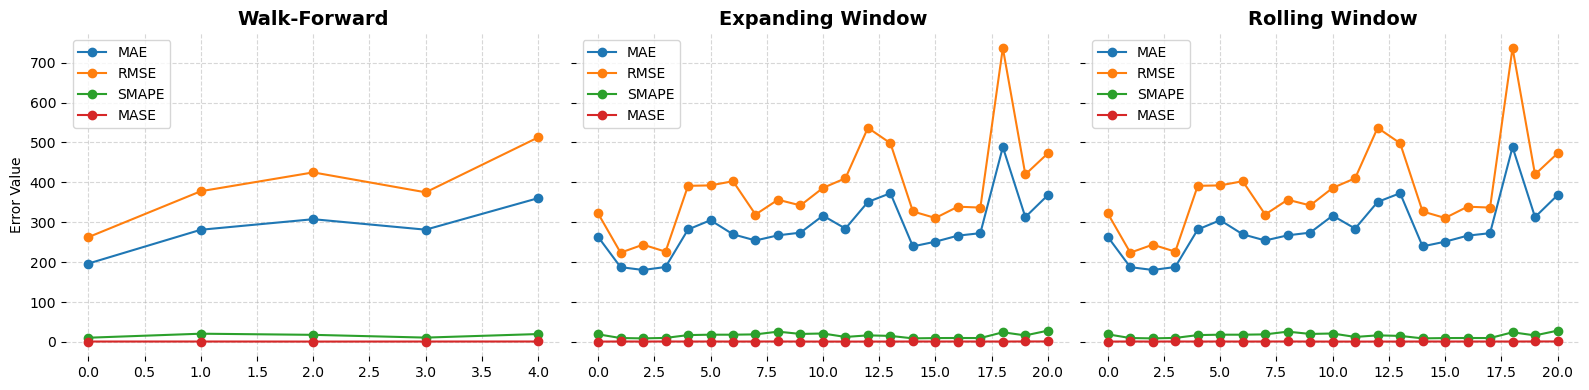

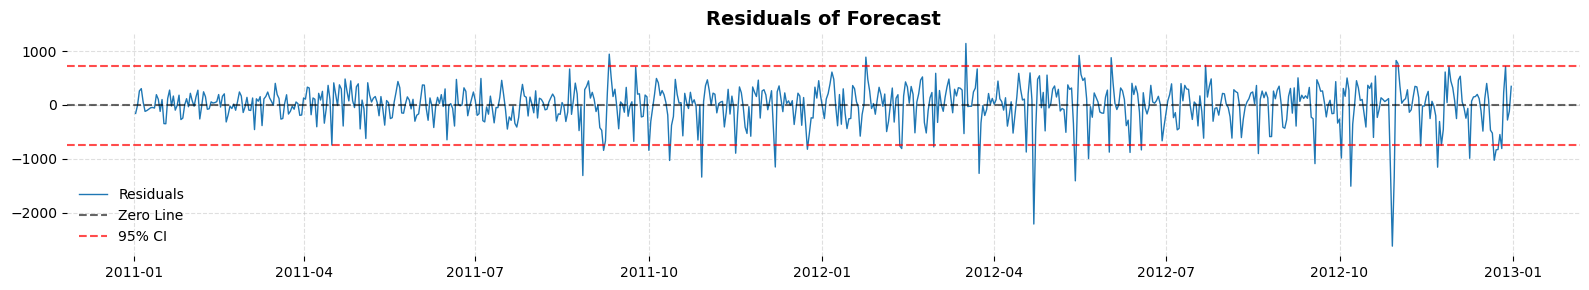

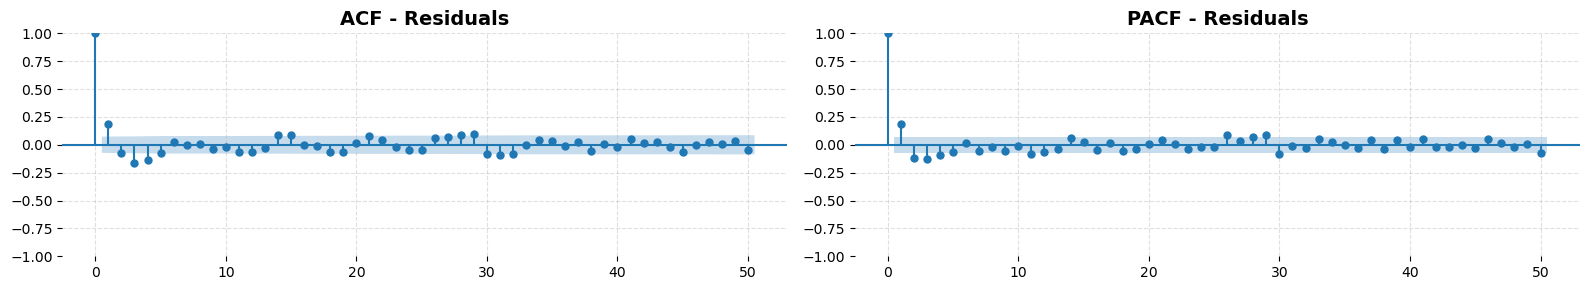

Model    Baseline          Improvement
MAE                       266.511489  278.586325             4.334325
RMSE                      374.674231  407.237227             7.996075
SMAPE                      16.546741    18.14243             8.795342
MASE                        0.956657         1.0             4.334325
DM Test p-value                                   0.14955323338068985
Statistical Significance                              Not Significant

---------------- TEST TEMPORAL BACKTESTING ----------------


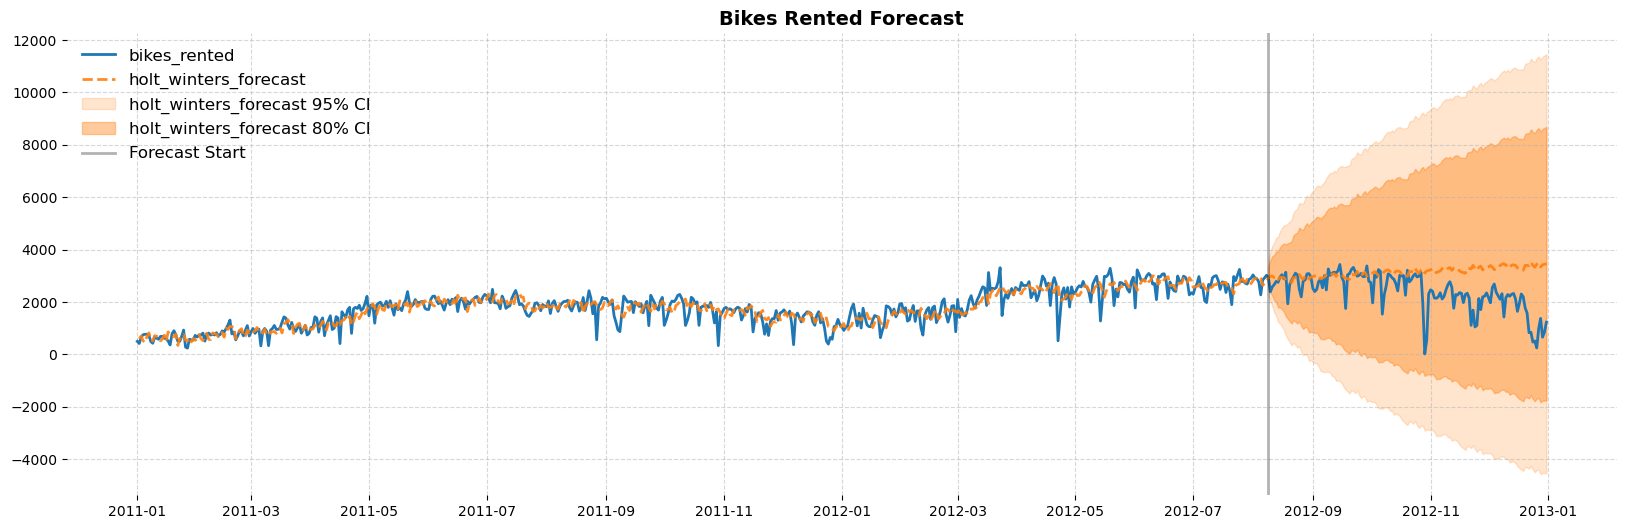

Model    Baseline           Improvement
MAE                       245.473861  265.528583              7.552754
RMSE                      338.452564  384.762166             12.035903
SMAPE                      15.983442   17.992191             11.164558
MASE                        0.924472         1.0              7.552754
DM Test p-value                                   0.034058100412085346
Statistical Significance                                   Significant

In [32]:
# Forecast
holt_winters_forecast_df = base_forecast.holt_winters_forecast(transformed_df, forecast_column, steps=60)

# Calculate metrics
holt_winters_forecast_metrics, holt_winters_forecast_comparison_results = validation.validate_forecast(naive_df=naive_forecast_df, forecast_df=holt_winters_forecast_df, baseline_df=naive_forecast_df, to_forecast_column = forecast_column, forecasted_column = 'holt_winters_forecast')

# Test
n_test = 145
naive_forecast_test_df = base_forecast.naive_forecast(transformed_df[:-n_test], forecast_column, steps=n_test)
holt_winters_forecast_test_df = transformed_df.merge(base_forecast.holt_winters_forecast(transformed_df[:-n_test], forecast_column, steps=n_test)[['date','holt_winters_forecast','is_future_forecast']], on = 'date', how = 'inner')
holt_winters_forecast_test_metrics, holt_winters_forecast_test_comparison_results = validation.test_forecast(naive_df=naive_forecast_test_df, forecast_df=holt_winters_forecast_test_df, baseline_df=naive_forecast_test_df, to_forecast_column = forecast_column, forecasted_column = 'holt_winters_forecast')

#### MOVING AVERAGE

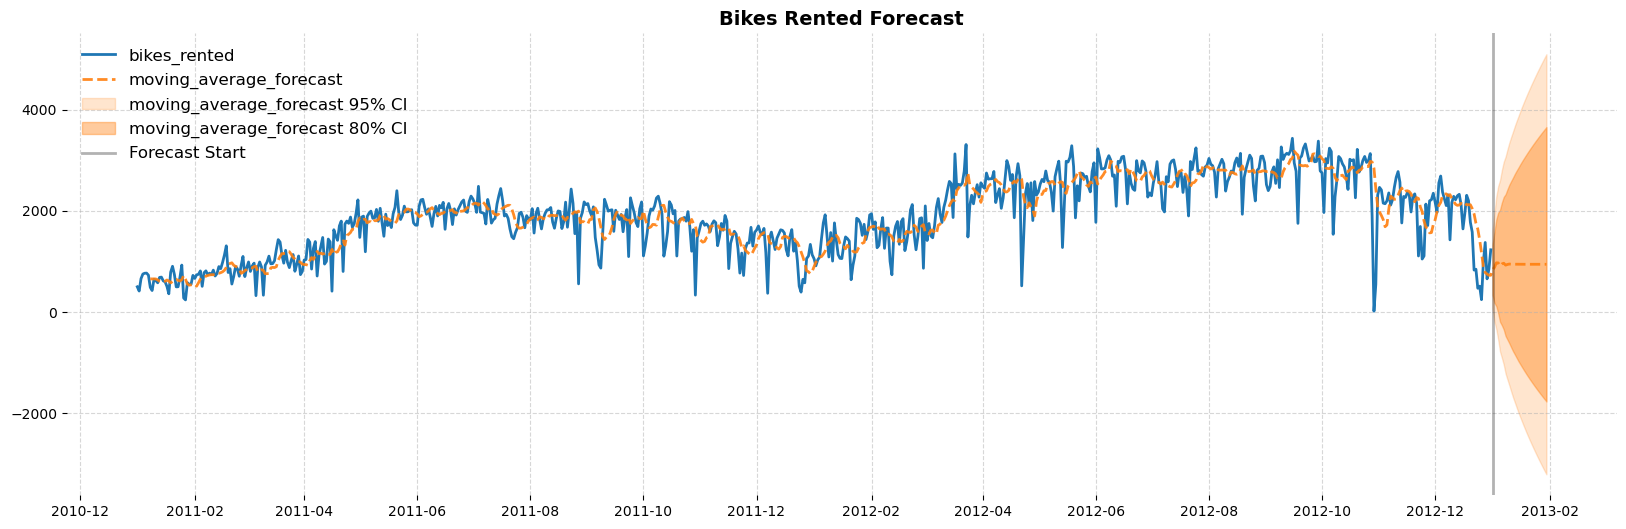

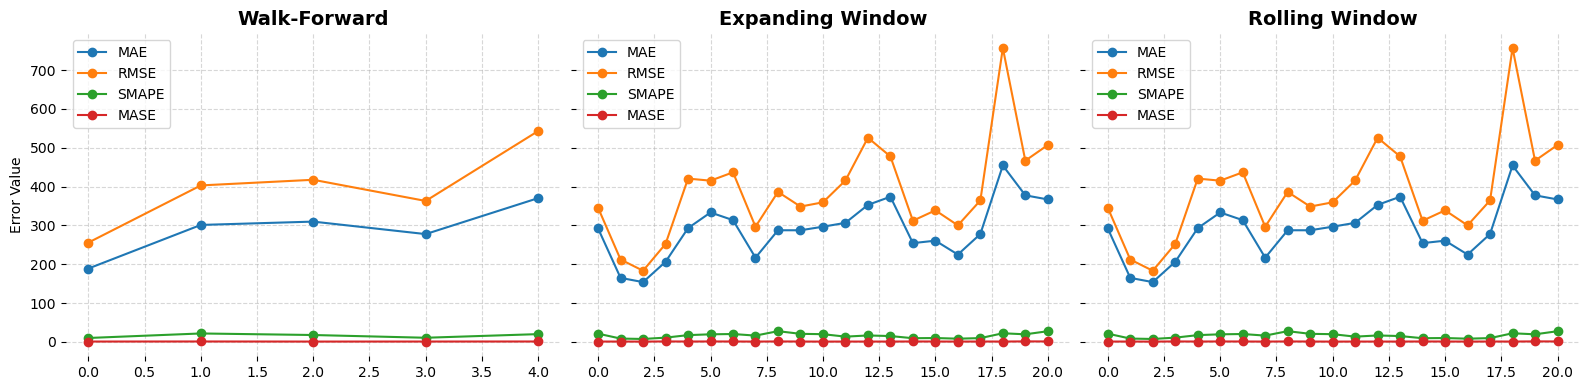

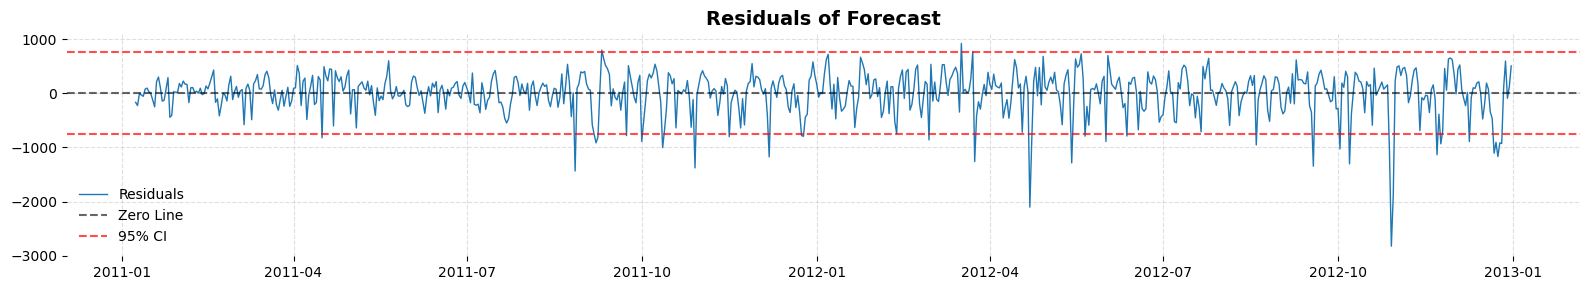

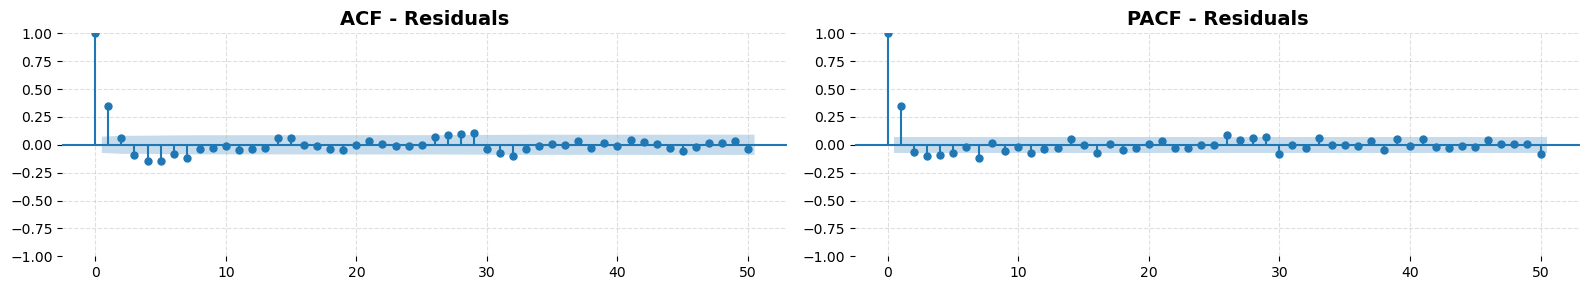

Model    Baseline         Improvement
MAE                       274.585627  278.586325            1.436071
RMSE                       386.10679  407.237227            5.188729
SMAPE                      16.963616    18.14243            6.497555
MASE                        0.979841         1.0            2.015898
DM Test p-value                                   0.5723513493242864
Statistical Significance                             Not Significant

---------------- TEST TEMPORAL BACKTESTING ----------------


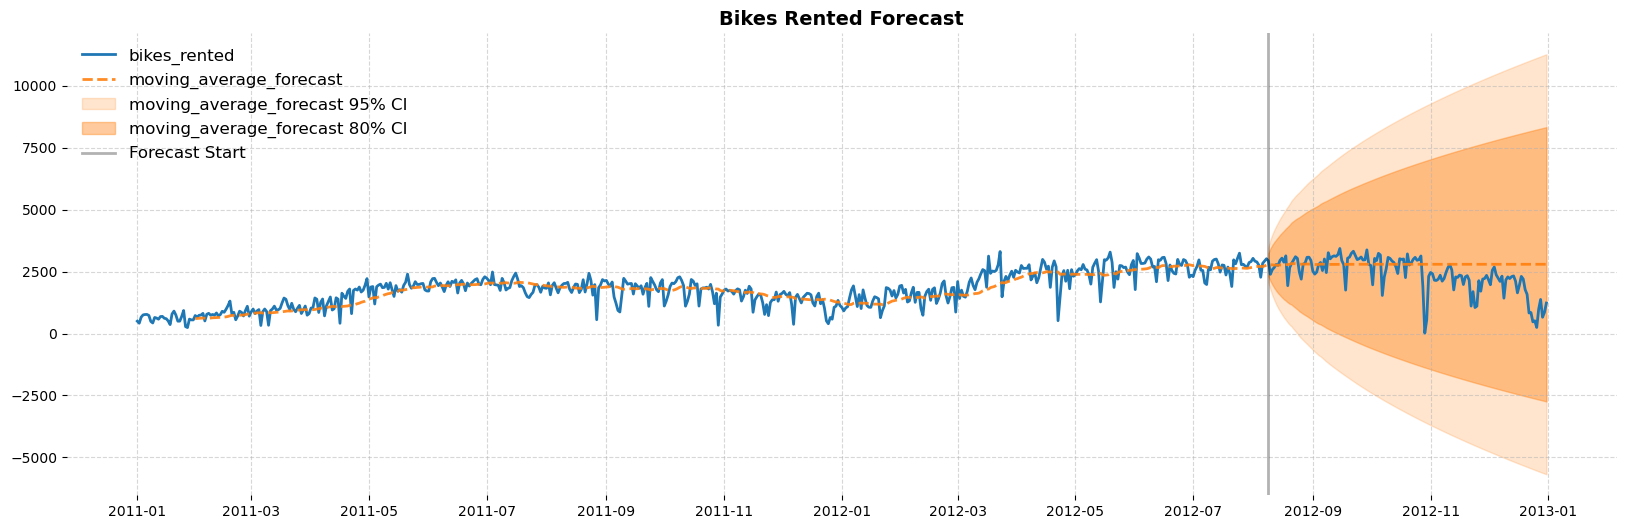

Model    Baseline        Improvement
MAE                       274.452885  265.528583          -3.360957
RMSE                      364.157232  384.762166           5.355239
SMAPE                      17.162401   17.992191           4.611943
MASE                        1.008027         1.0          -0.802672
DM Test p-value                                   0.852710841952852
Statistical Significance                            Not Significant

In [33]:
# Forecast
moving_average_forecast_df = base_forecast.moving_average_forecast(transformed_df, forecast_column, steps=30, window = 7)

# Calculate metrics
moving_average_forecast_metrics, moving_average_forecast_comparison_results = validation.validate_forecast(naive_df=naive_forecast_df, forecast_df=moving_average_forecast_df, baseline_df=naive_forecast_df, to_forecast_column = forecast_column, forecasted_column = 'moving_average_forecast')

# Test
n_test = 145
naive_forecast_test_df = base_forecast.naive_forecast(transformed_df[:-n_test], forecast_column, steps=n_test)
moving_average_forecast_test_df = transformed_df.merge(base_forecast.moving_average_forecast(transformed_df[:-n_test], forecast_column, steps=n_test, window = 30)[['date','moving_average_forecast','is_future_forecast']], on = 'date', how = 'inner')
moving_average_forecast_metrics, moving_average_forecast_comparison_results = validation.test_forecast(naive_df=naive_forecast_test_df, forecast_df=moving_average_forecast_test_df, baseline_df=naive_forecast_test_df, to_forecast_column = forecast_column, forecasted_column = 'moving_average_forecast')

### STATISTICAL FORECASTING

#### AR

In [34]:
from statsmodels.tsa.ar_model import AutoReg

def AR_forecast(transformed_df, forecast_column, steps=60, lags=7):
    df = transformed_df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)

    ts = df[forecast_column]
    model = AutoReg(ts, lags=lags, old_names=False).fit()
    # Prepend NaNs for the initial lags
    fitted_values = [float('nan')] * lags + list(model.fittedvalues)
    df['AR_forecast'] = fitted_values
    df['is_future_forecast'] = False

    future_forecast = model.forecast(steps=steps)
    last_date = df['date'].max()
    future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, steps + 1)]
    future_df = pd.DataFrame({
        'date': future_dates,
        forecast_column: [pd.NA] * steps,
        'AR_forecast': future_forecast,
        'is_future_forecast': [True] * steps
    })

    for col in transformed_df.columns:
        if col not in future_df.columns:
            future_df[col] = pd.NA

    cols = list(transformed_df.columns) + ['AR_forecast', 'is_future_forecast']
    future_df = future_df[cols]
    result_df = pd.concat([df, future_df], ignore_index=True)
    return result_df


In [35]:
min_MASE = 1
min_lag = 1 

for lag in range(1, 100):
    # Forecast
    AR_forecast_df = AR_forecast(transformed_df, forecast_column, lags = lag, steps=60)

    # Calculate metrics
    AR_forecast_metrics, AR_forecast_comparison_results = validation.validate_forecast(naive_df=naive_forecast_df, forecast_df=AR_forecast_df, baseline_df=naive_forecast_df, to_forecast_column = forecast_column, forecasted_column = 'AR_forecast', plot_results=False)

    if min_MASE > AR_forecast_metrics['MASE']:
        min_MASE = AR_forecast_metrics['MASE']
        min_lag = lag
        print('New best MASE: ', np.round(min_MASE, 6), ' with lag: ', min_lag)

New best MASE:  0.991166  with lag:  1
New best MASE:  0.973873  with lag:  2
New best MASE:  0.951945  with lag:  3
New best MASE:  0.939521  with lag:  4
New best MASE:  0.920305  with lag:  5
New best MASE:  0.905429  with lag:  6
New best MASE:  0.900386  with lag:  7
New best MASE:  0.893916  with lag:  8
New best MASE:  0.892369  with lag:  9
New best MASE:  0.890551  with lag:  10
New best MASE:  0.889948  with lag:  11
New best MASE:  0.883584  with lag:  12
New best MASE:  0.882466  with lag:  13
New best MASE:  0.873368  with lag:  14
New best MASE:  0.872903  with lag:  16
New best MASE:  0.872335  with lag:  18
New best MASE:  0.871301  with lag:  20
New best MASE:  0.870631  with lag:  21
New best MASE:  0.869717  with lag:  23
New best MASE:  0.869455  with lag:  26
New best MASE:  0.867762  with lag:  27
New best MASE:  0.867245  with lag:  33
New best MASE:  0.86684  with lag:  34
New best MASE:  0.866235  with lag:  37
New best MASE:  0.866229  with lag:  43
New best M

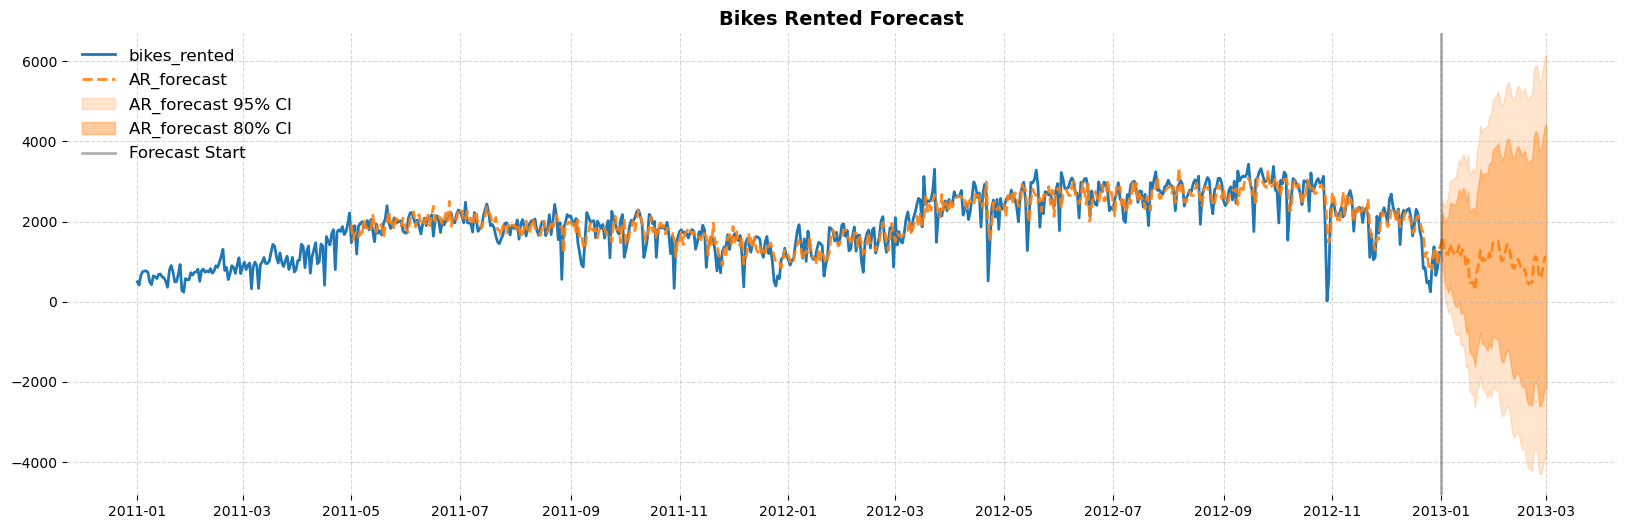

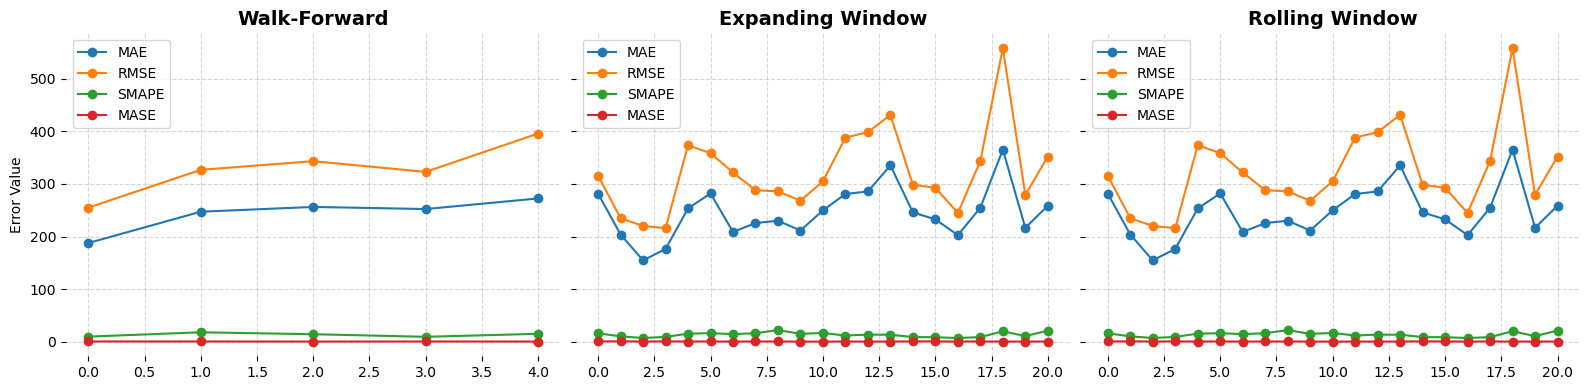

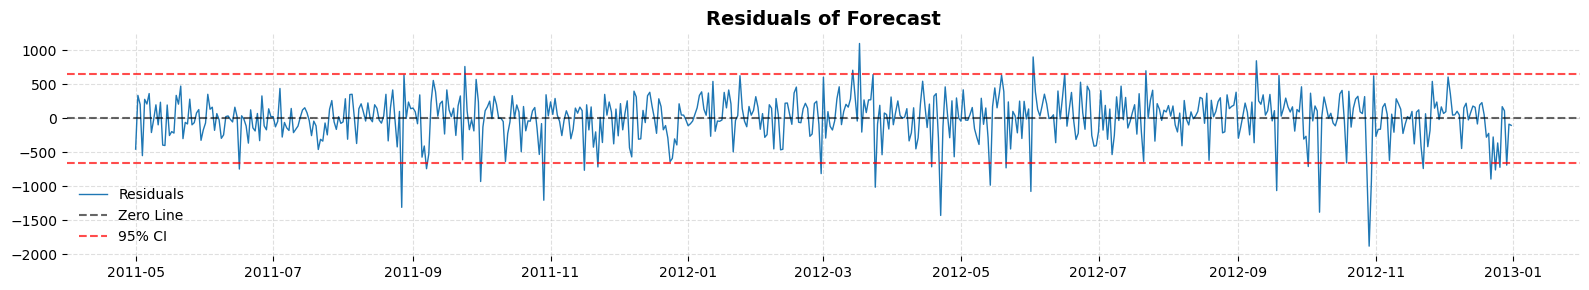

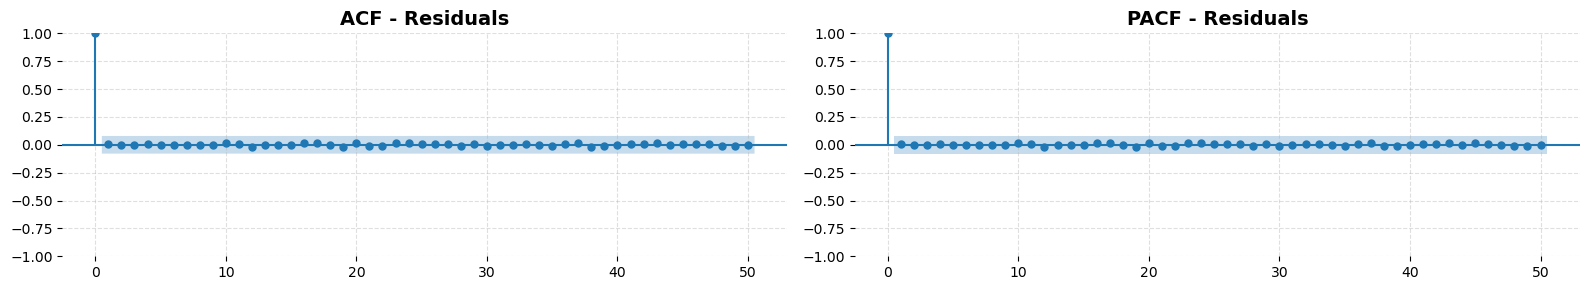

Model    Baseline            Improvement
MAE                       244.255082  278.586325              12.323377
RMSE                      332.187651  407.237227              18.428958
SMAPE                      13.742669    18.14243              24.251226
MASE                        0.834494         1.0              16.550608
DM Test p-value                                   9.054612178159134e-08
Statistical Significance                                    Significant

---------------- TEST TEMPORAL BACKTESTING ----------------


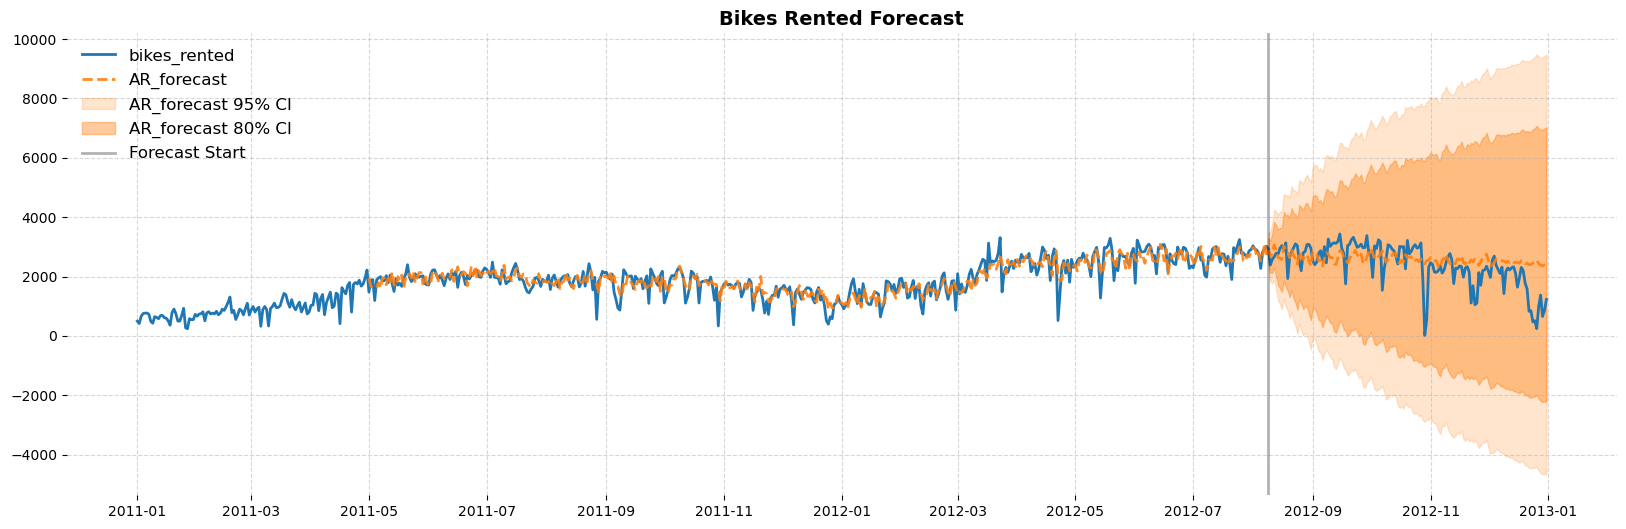

Model    Baseline            Improvement
MAE                        223.59652  265.528583               15.79192
RMSE                      298.964371  384.762166              22.298917
SMAPE                      12.802502   17.992191              28.844119
MASE                        0.796575         1.0              20.342486
DM Test p-value                                   6.001031699718007e-08
Statistical Significance                                    Significant

In [36]:
# Forecast
lags = 120
AR_forecast_df = AR_forecast(transformed_df, forecast_column, lags = lags, steps=60)

# Calculate metrics
AR_forecast_metrics, AR_forecast_comparison_results = validation.validate_forecast(naive_df=naive_forecast_df, forecast_df=AR_forecast_df, baseline_df=naive_forecast_df, to_forecast_column = forecast_column, forecasted_column = 'AR_forecast')

# Test
n_test = 145
naive_forecast_test_df = base_forecast.naive_forecast(transformed_df[:-n_test], forecast_column, steps=n_test)
AR_forecast_test_df = transformed_df.merge(AR_forecast(transformed_df[:-n_test], forecast_column, lags = lags, steps=n_test)[['date','AR_forecast','is_future_forecast']], on = 'date', how = 'inner')
AR_forecast_metrics, AR_forecast_comparison_results = validation.test_forecast(naive_df=naive_forecast_test_df, forecast_df=AR_forecast_test_df, baseline_df=naive_forecast_test_df, to_forecast_column = forecast_column, forecasted_column = 'AR_forecast')

#### ARMA AND ARIMA

In [37]:
from statsmodels.tsa.arima.model import ARIMA

def arima_forecast(transformed_df, forecast_column, steps=60, order=(1, 1, 1)):
    df = transformed_df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)

    ts = df[forecast_column]
    model = ARIMA(ts, order=order).fit()
    fitted = model.predict(start=0, end=len(ts)-1)
    df['arima_forecast'] = np.nan
    df.loc[df.index[:len(fitted)], 'arima_forecast'] = fitted.values
    df['is_future_forecast'] = False

    future_forecast = model.forecast(steps=steps)
    last_date = df['date'].max()
    future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, steps + 1)]
    future_df = pd.DataFrame({
        'date': future_dates,
        forecast_column: [np.nan] * steps,
        'arima_forecast': future_forecast,
        'is_future_forecast': [True] * steps
    })

    for col in transformed_df.columns:
        if col not in future_df.columns:
            future_df[col] = np.nan

    cols = list(transformed_df.columns) + ['arima_forecast', 'is_future_forecast']
    future_df = future_df[cols]
    result_df = pd.concat([df, future_df], ignore_index=True)
    return result_df

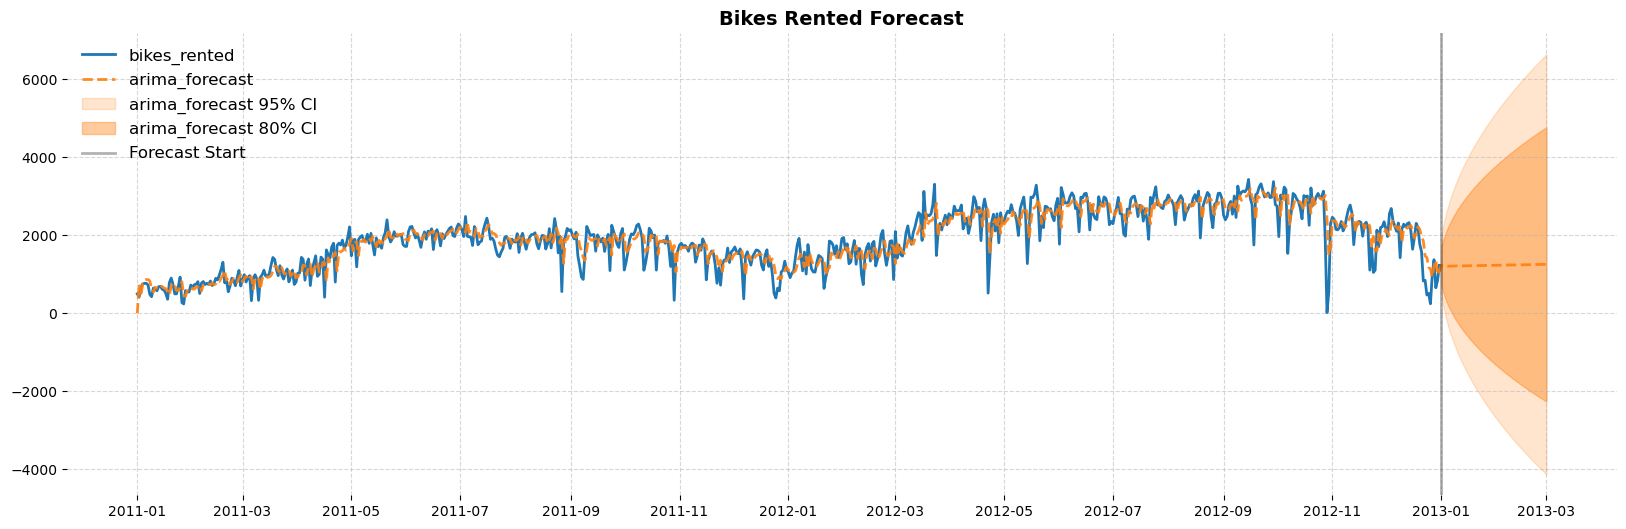

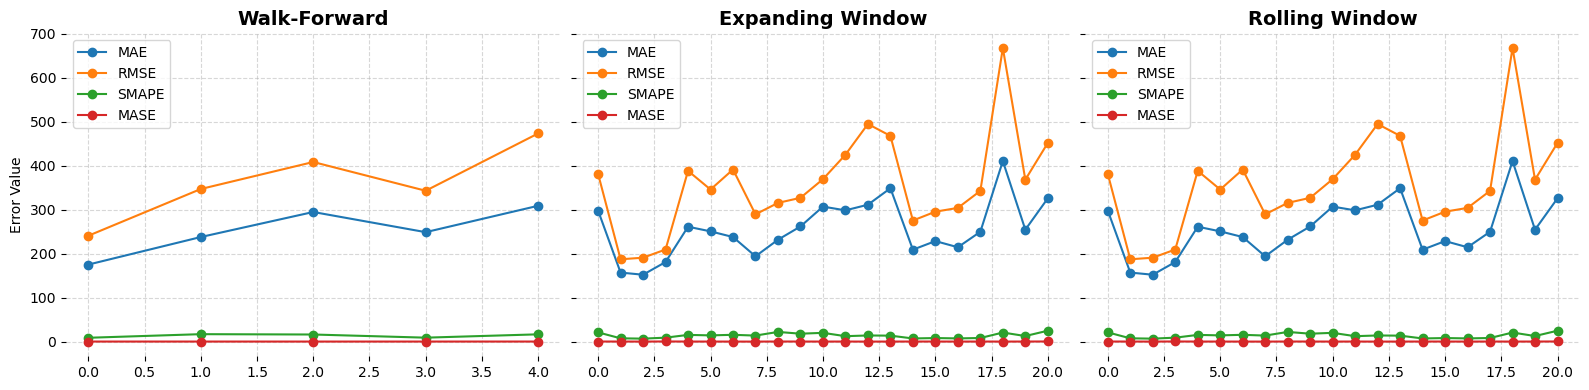

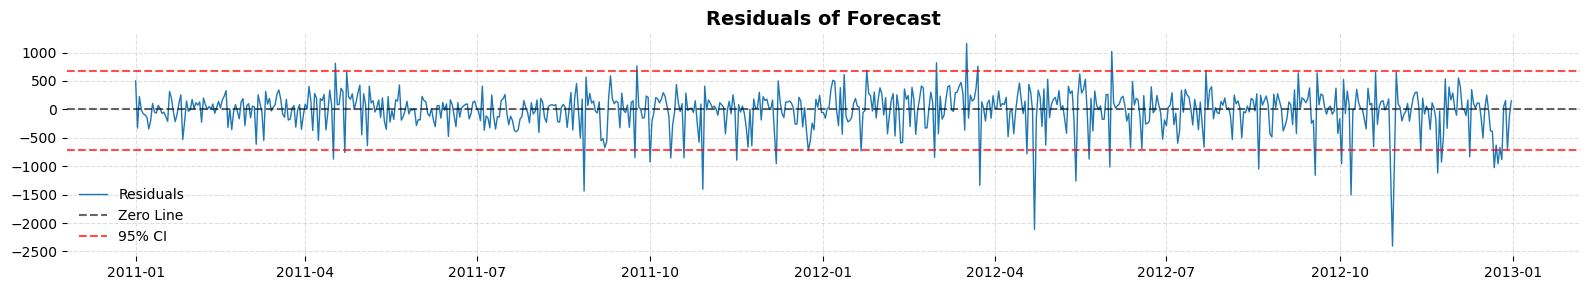

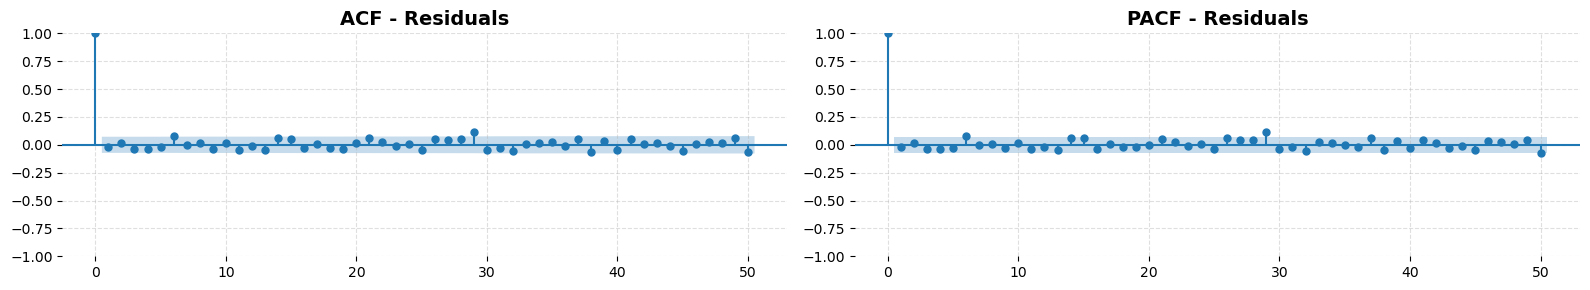

Model    Baseline            Improvement
MAE                       243.465714  278.586325              12.606725
RMSE                      354.762209  407.237227              12.885614
SMAPE                      15.402264    18.14243              15.103631
MASE                        0.873933         1.0              12.606725
DM Test p-value                                   7.955264192874581e-08
Statistical Significance                                    Significant

---------------- TEST TEMPORAL BACKTESTING ----------------


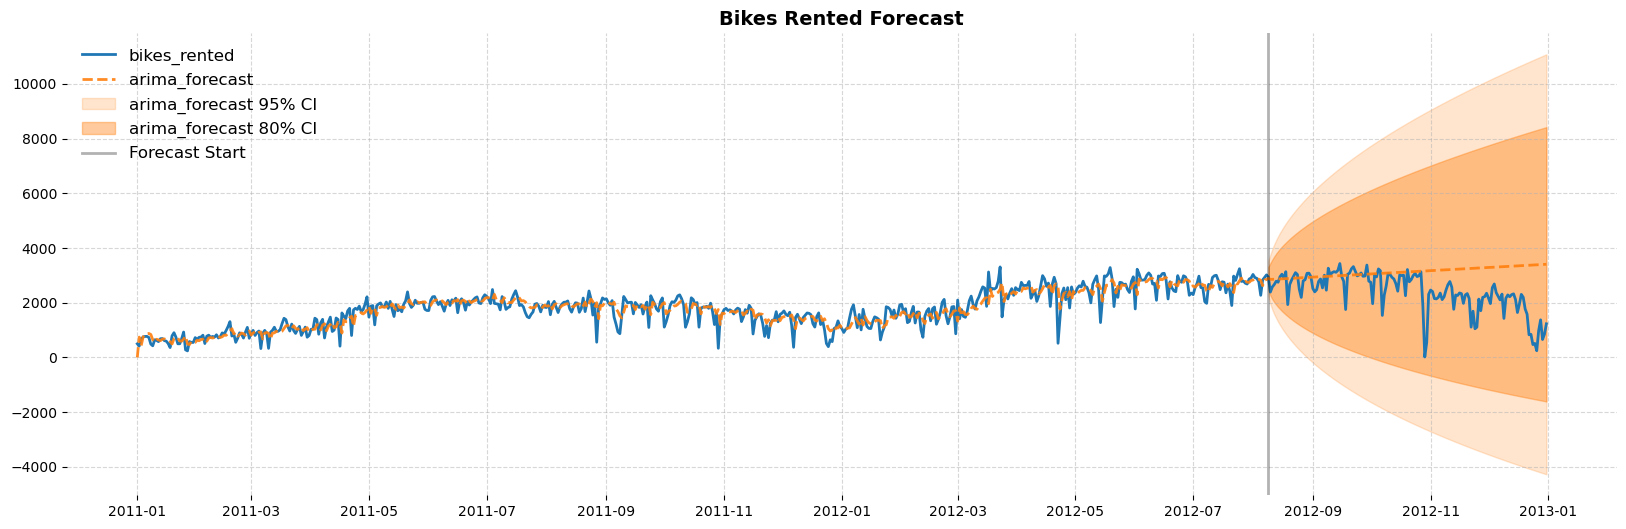

Model    Baseline            Improvement
MAE                       231.003565  265.528583              13.002374
RMSE                      324.742409  384.762166              15.599184
SMAPE                      15.284988   17.992191              15.046545
MASE                        0.869976         1.0              13.002374
DM Test p-value                                   4.752618230017122e-06
Statistical Significance                                    Significant

In [38]:
# Forecast
order=(3, 2, 3)
ARIMA_forecast_df = arima_forecast(transformed_df, forecast_column, order=order, steps=60)

# Calculate metrics
ARIMA_forecast_metrics, ARIMA_forecast_comparison_results = validation.validate_forecast(naive_df=naive_forecast_df, forecast_df=ARIMA_forecast_df, baseline_df=naive_forecast_df, to_forecast_column = forecast_column, forecasted_column = 'arima_forecast')

# Test
n_test = 145
naive_forecast_test_df = base_forecast.naive_forecast(transformed_df[:-n_test], forecast_column, steps=n_test)
ARIMA_forecast_test_df = transformed_df.merge(arima_forecast(transformed_df[:-n_test], forecast_column, order=order, steps=n_test)[['date','arima_forecast','is_future_forecast']], on = 'date', how = 'inner')
ARIMA_forecast_metrics, ARIMA_forecast_comparison_results = validation.test_forecast(naive_df=naive_forecast_test_df, forecast_df=ARIMA_forecast_test_df, baseline_df=naive_forecast_test_df, to_forecast_column = forecast_column, forecasted_column = 'arima_forecast')

##### AUTO-ARIMA

In [39]:
min_MASE = float('inf')
min_order = None

possible_ps = range(0, 6)
possible_ds = range(0, 3)
possible_qs = range(0, 6)

if False:
    for order in itertools.product(possible_ps, possible_ds, possible_qs):
        ARIMA_forecast_df = arima_forecast(transformed_df, forecast_column, order=order, steps=60)
        ARIMA_forecast_metrics, _ = validation.validate_forecast(
            naive_df=naive_forecast_df,
            forecast_df=ARIMA_forecast_df,
            baseline_df=naive_forecast_df,
            to_forecast_column=forecast_column,
            forecasted_column='arima_forecast',
            plot_results=False
        )
        if ARIMA_forecast_metrics['MASE'] < min_MASE:
            min_MASE = ARIMA_forecast_metrics['MASE']
            min_order = order
            print('New best MASE:', round(min_MASE, 6), 'with order:', order)

    ARIMA_forecast_df = arima_forecast(transformed_df, forecast_column, order=min_order, steps=60)

    # Calculate metrics
    ARIMA_forecast_metrics, ARIMA_forecast_comparison_results = validation.validate_forecast(naive_df=naive_forecast_df, forecast_df=ARIMA_forecast_df, baseline_df=naive_forecast_df, to_forecast_column = forecast_column, forecasted_column = 'arima_forecast')

    # Test
    n_test = 145
    naive_forecast_test_df = base_forecast.naive_forecast(transformed_df[:-n_test], forecast_column, steps=n_test)
    ARIMA_forecast_test_df = transformed_df.merge(arima_forecast(transformed_df[:-n_test], forecast_column, order=min_order, steps=n_test)[['date','arima_forecast','is_future_forecast']], on = 'date', how = 'inner')
    ARIMA_forecast_metrics, ARIMA_forecast_comparison_results = validation.test_forecast(naive_df=naive_forecast_test_df, forecast_df=ARIMA_forecast_test_df, baseline_df=naive_forecast_test_df, to_forecast_column = forecast_column, forecasted_column = 'arima_forecast')

#### SARIMA

In [40]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def sarima_forecast(transformed_df, forecast_column, steps=60, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0)):
    df = transformed_df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)

    ts = df[forecast_column]
    model = SARIMAX(ts, order=order, seasonal_order=seasonal_order).fit(disp=False)
    fitted = model.predict(start=0, end=len(ts) - 1)
    df['sarima_forecast'] = np.nan
    df.loc[df.index[:len(fitted)], 'sarima_forecast'] = fitted.values
    df['is_future_forecast'] = False

    future_forecast = model.forecast(steps=steps)
    last_date = df['date'].max()
    future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, steps + 1)]
    future_df = pd.DataFrame({
        'date': future_dates,
        forecast_column: [np.nan] * steps,
        'sarima_forecast': future_forecast,
        'is_future_forecast': [True] * steps
    })

    for col in transformed_df.columns:
        if col not in future_df.columns:
            future_df[col] = np.nan

    cols = list(transformed_df.columns) + ['sarima_forecast', 'is_future_forecast']
    future_df = future_df[cols]
    result_df = pd.concat([df, future_df], ignore_index=True)
    return result_df

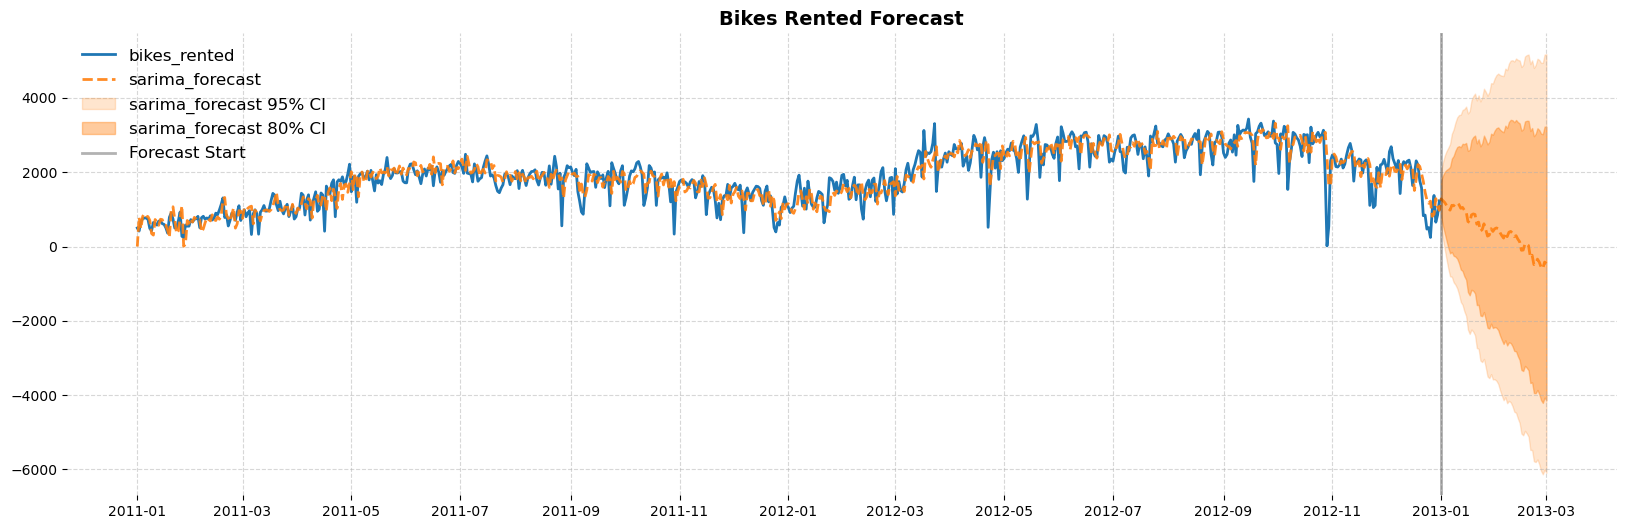

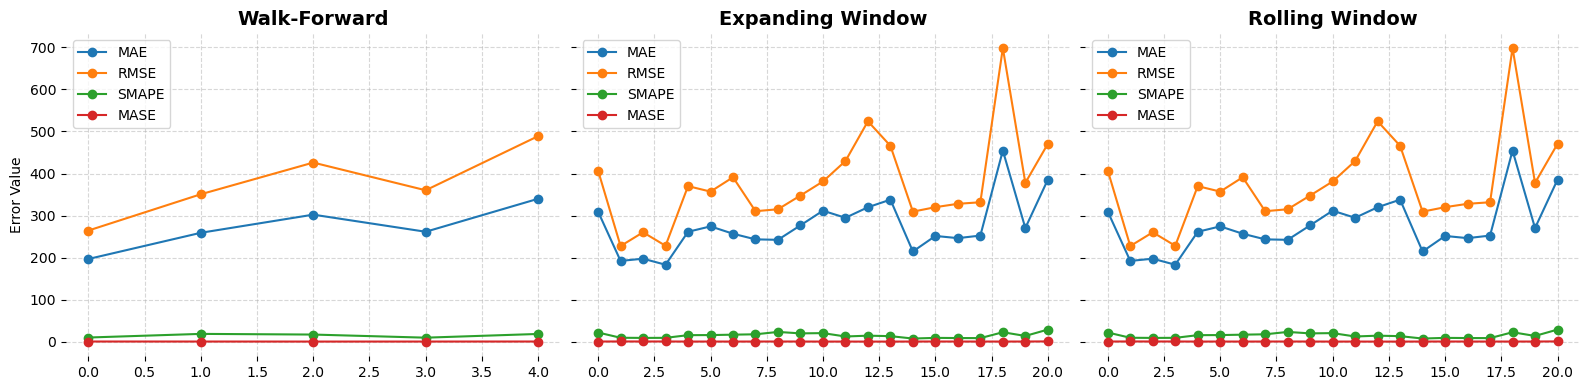

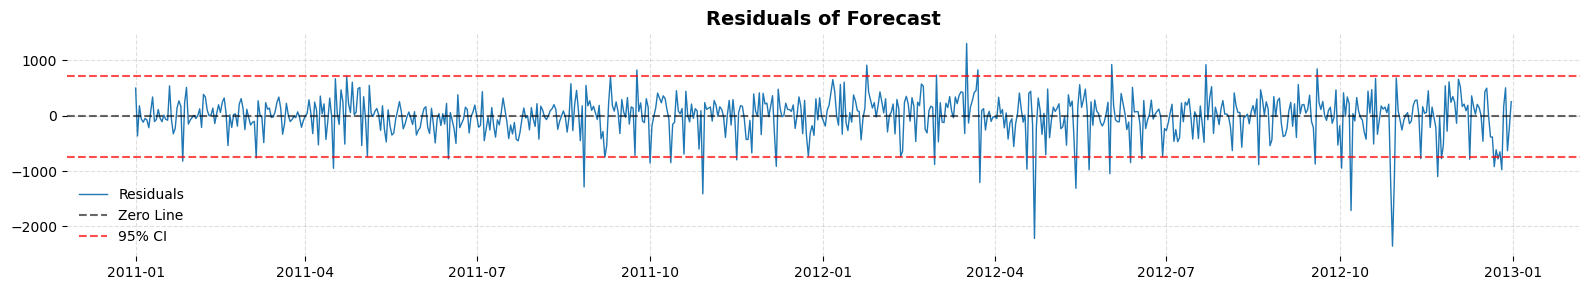

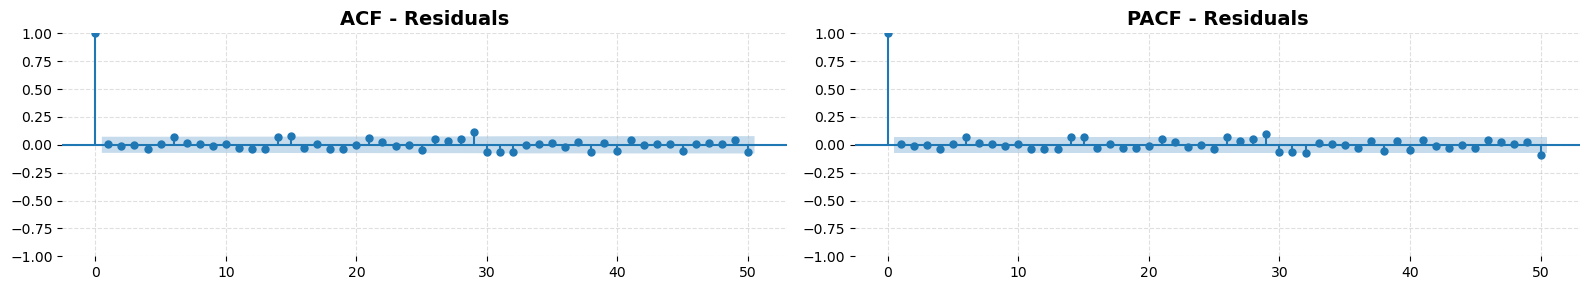

Model    Baseline           Improvement
MAE                       260.862518  278.586325              6.362052
RMSE                      370.679484  407.237227              8.977014
SMAPE                      16.886843    18.14243              6.920723
MASE                        0.936379         1.0              6.362052
DM Test p-value                                   0.014878886061314342
Statistical Significance                                   Significant

---------------- TEST TEMPORAL BACKTESTING ----------------


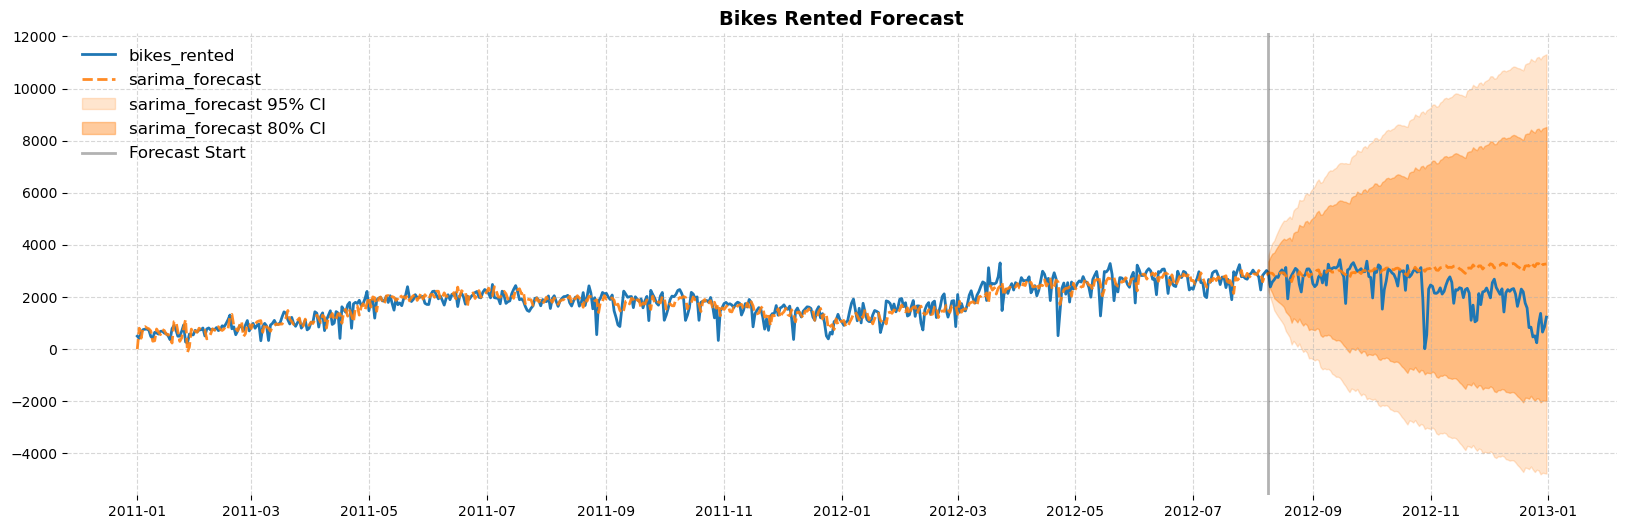

Model    Baseline          Improvement
MAE                       247.817475  265.528583             6.670132
RMSE                      340.334235  384.762166            11.546856
SMAPE                      16.993544   17.992191             5.550444
MASE                        0.933299         1.0             6.670132
DM Test p-value                                   0.02930638988239088
Statistical Significance                                  Significant

In [41]:
# Forecast
order = (3, 2, 3)
seasonal_order = (1, 1, 1, 30)
SARIMA_forecast_df = sarima_forecast(transformed_df, forecast_column, order=order, seasonal_order=seasonal_order, steps=60)

# Calculate metrics
SARIMA_forecast_metrics, SARIMA_forecast_comparison_results = validation.validate_forecast(naive_df=naive_forecast_df, forecast_df=SARIMA_forecast_df, baseline_df=naive_forecast_df, to_forecast_column = forecast_column, forecasted_column = 'sarima_forecast')

# Test
n_test = 145
naive_forecast_test_df = base_forecast.naive_forecast(transformed_df[:-n_test], forecast_column, steps=n_test)
SARIMA_forecast_test_df = transformed_df.merge(sarima_forecast(transformed_df[:-n_test], forecast_column, order=order, seasonal_order=seasonal_order, steps=n_test)[['date','sarima_forecast','is_future_forecast']], on = 'date', how = 'inner')
SARIMA_forecast_metrics, SARIMA_forecast_comparison_results = validation.test_forecast(naive_df=naive_forecast_test_df, forecast_df=SARIMA_forecast_test_df, baseline_df=naive_forecast_test_df, to_forecast_column = forecast_column, forecasted_column = 'sarima_forecast')

##### AUTO-SARIMA

In [42]:
min_MASE = float('inf')
best_order = None
best_seasonal_order = None

# Define ranges for non-seasonal (p,d,q) and seasonal (P,D,Q,m) parameters.
possible_orders = [(p, d, q) for p in range(1, 4)   # p: 0,1,2,3
                              for d in range(1, 3)   # d: 0,1,2
                              for q in range(1, 4)]  # q: 0,1,2,3

# m (period) must be > 1, for example 7, 14 or 30.
possible_seasonal_orders = [(P, D, Q, m)
                            for P in range(0, 1)  # P: 0,1
                            for D in range(0, 1)  # D: 0,1
                            for Q in range(0, 1)  # Q: 0,1
                            for m in [7, 14, 30] if m > 1]

if False:
    for order in possible_orders:
        for seasonal_order in possible_seasonal_orders:
            try:
                forecast_df = sarima_forecast(transformed_df, forecast_column,
                                            order=order,
                                            seasonal_order=seasonal_order,
                                            steps=60)
                SARIMA_forecast_metrics, _ = validation.validate_forecast(
                    naive_df=naive_forecast_df,
                    forecast_df=forecast_df,
                    baseline_df=naive_forecast_df,
                    to_forecast_column=forecast_column,
                    forecasted_column='sarima_forecast',
                    plot_results=False
                )
                if SARIMA_forecast_metrics['MASE'] < min_MASE:
                    min_MASE = SARIMA_forecast_metrics['MASE']
                    best_order = order
                    best_seasonal_order = seasonal_order
                    print('New best MASE:', np.round(min_MASE, 6),
                        'with order:', order,
                        'and seasonal_order:', seasonal_order)
            except Exception as e:
                print('Error with order:', order, 'and seasonal_order:', seasonal_order, e)

    SARIMA_forecast_df = sarima_forecast(transformed_df, forecast_column, order=best_order, seasonal_order=best_seasonal_order, steps=60)

    # Calculate metrics
    SARIMA_forecast_metrics, SARIMA_forecast_comparison_results = validation.validate_forecast(naive_df=naive_forecast_df, forecast_df=SARIMA_forecast_df, baseline_df=naive_forecast_df, to_forecast_column = forecast_column, forecasted_column = 'sarima_forecast')

    # Test
    n_test = 145
    naive_forecast_test_df = base_forecast.naive_forecast(transformed_df[:-n_test], forecast_column, steps=n_test)
    SARIMA_forecast_test_df = transformed_df.merge(sarima_forecast(transformed_df[:-n_test], forecast_column, order=best_order, seasonal_order=best_seasonal_order, steps=n_test)[['date','sarima_forecast','is_future_forecast']], on = 'date', how = 'inner')
    SARIMA_forecast_metrics, SARIMA_forecast_comparison_results = validation.test_forecast(naive_df=naive_forecast_test_df, forecast_df=SARIMA_forecast_test_df, baseline_df=naive_forecast_test_df, to_forecast_column = forecast_column, forecasted_column = 'sarima_forecast')

## MULTIVARIANT FORECASTING

### MULTIVARIANT FEATURE ENGINEERING

#### TIME NORMALIZATION

In [74]:
use_time_normalization = False
base_df = eda_df.copy()
target_time_norm_column = target_column + "_time_norm"

if use_time_normalization:
    forecast_column = target_time_norm_column
    base_df[forecast_column] = eda_df[target_column] / eda_df["date"].dt.days_in_month
    try:
        base_df.drop(columns=target_column, inplace=True)
    except:
        pass
else:
    forecast_column = target_column
    try:
        base_df.drop(columns=target_time_norm_column, inplace=True)
    except:
        pass

print('Forecast variable: ', forecast_column)
display(base_df.head(1))

Forecast variable:  bikes_rented


date season year month holiday weekday workingday weather  \
0 2011-01-01      1    0     1       0       6          0       2   

   temperature  temperature_sensation  humidity  windspeed  casual_users  \
0     0.344167               0.363625  0.805833   0.160446           331   

   registered_users  bikes_rented extreme_weather  
0               654           985               0

#### ONE HOT ENCODING

In [75]:
original_features_columns = list(base_df.drop(columns=["date", forecast_column,"casual_users","registered_users"], errors="ignore").columns)
original_numeric_features_columns = list(base_df.drop(columns=["date", forecast_column,"casual_users","registered_users"], errors="ignore").select_dtypes(include=["number"]).columns)

print(original_features_columns)
print(original_numeric_features_columns)

['season', 'year', 'month', 'holiday', 'weekday', 'workingday', 'weather', 'temperature', 'temperature_sensation', 'humidity', 'windspeed', 'extreme_weather']
['temperature', 'temperature_sensation', 'humidity', 'windspeed']


In [76]:
one_hot_df = pd.get_dummies(df, drop_first=True)
one_hot_df = one_hot_df.astype({col: int for col in one_hot_df.select_dtypes(bool).columns})
one_hot_features_columns = list(one_hot_df.drop(columns=original_features_columns + ["bikes_rented", "casual_users", "registered_users"], errors="ignore").columns)
print(one_hot_df.dtypes)

date                     datetime64[ns]
temperature                     float64
temperature_sensation           float64
humidity                        float64
windspeed                       float64
casual_users                      int64
registered_users                  int64
bikes_rented                      int64
season_2                          int64
season_3                          int64
season_4                          int64
year_1                            int64
month_10                          int64
month_11                          int64
month_12                          int64
month_2                           int64
month_3                           int64
month_4                           int64
month_5                           int64
month_6                           int64
month_7                           int64
month_8                           int64
month_9                           int64
holiday_1                         int64
weekday_1                         int64


#### INITIAL FEATURES TRANSFORMATION

In [77]:
check_transformations_df = base_df[['date'] + original_numeric_features_columns + [forecast_column]]

print_title('Recommended Transformations')
transformations = utils.check_transformations(check_transformations_df)

print('\n')
print_title('DF Prepared')
transformed_df = utils.apply_transformations(check_transformations_df, transformations)
print('Forecast variable: ', forecast_column)

one_hot_and_transformed_features_df = one_hot_df.drop(columns=original_numeric_features_columns + [forecast_column]).merge(transformed_df, on = 'date')
display(one_hot_and_transformed_features_df.head())

--------------- Recommended Transformations ---------------
                      stationary recommended_transformation
temperature                False                        log
temperature_sensation      False                     boxcox
humidity                    True                       none
windspeed                   True                       none
bikes_rented               False                     boxcox


----------------------- DF Prepared -----------------------
Transformations applied successfully.


date  temperature  temperature_sensation  humidity  windspeed  \
0 2011-01-01     0.295774               0.391774  0.805833   0.160446   
1 2011-01-02     0.310039               0.380418  0.696087   0.248539   
2 2011-01-03     0.179287               0.197255  0.437273   0.248309   
3 2011-01-04     0.182322               0.221931  0.590435   0.160296   
4 2011-01-05     0.204537               0.240698  0.436957   0.186900   

   bikes_rented  
0    499.329506  
1    415.834439  
2    659.495676  
3    750.805907  
4    766.938328

Forecast variable:  bikes_rented


date  casual_users  registered_users  season_2  season_3  season_4  \
0 2011-01-01           331               654         0         0         0   
1 2011-01-02           131               670         0         0         0   
2 2011-01-03           120              1229         0         0         0   
3 2011-01-04           108              1454         0         0         0   
4 2011-01-05            82              1518         0         0         0   

   year_1  month_10  month_11  month_12  month_2  month_3  month_4  month_5  \
0       0         0         0         0        0        0        0        0   
1       0         0         0         0        0        0        0        0   
2       0         0         0         0        0        0        0        0   
3       0         0         0         0        0        0        0        0   
4       0         0         0         0        0        0        0        0   

   month_6  month_7  month_8  month_9  holiday_1  weekday_1  weekday_2  \
0        0        0        0        0          0          0          0   
1        0        0        0        0          0          0          0   
2        0        0        0        0          0          1          0   
3        0        0        0        0          0          0          1   
4        0        0        0        0          0          0          0   

   weekday_3  weekday_4  weekday_5  weekday_6  workingday_1  weather_2  \
0          0          0          0          1             0          1   
1          0          0          0          0             0          1   
2          0          0          0          0             1          0   
3          0          0          0          0             1          0   
4          1          0          0          0             1          0   

   weather_3  extreme_weather_1  temperature  temperature_sensation  humidity  \
0          0                  0     0.295774               0.391774  0.805833   
1          0                  0     0.310039               0.380418  0.696087   
2          0                  0     0.179287               0.197255  0.437273   
3          0                  0     0.182322               0.221931  0.590435   
4          0                  0     0.204537               0.240698  0.436957   

   windspeed  bikes_rented  
0   0.160446    499.329506  
1   0.248539    415.834439  
2   0.248309    659.495676  
3   0.160296    750.805907  
4   0.186900    766.938328

#### NEW FEATURES CREATION

In [ ]:
def add_lag_and_ma_features(df, lag_features, lags=None, ma_windows=None):
    transformed_df = df.copy()
    created_features = []

    if lags:
        for lag in lags:
            for feature in lag_features:
                col_name = f"{feature}_lag{lag}"
                transformed_df[col_name] = transformed_df[feature].shift(lag)
                created_features.append(col_name)

    if ma_windows:
        for ma in ma_windows:
            for feature in lag_features:
                col_name = f"{feature}_ma{ma}"
                transformed_df[col_name] = transformed_df[feature].shift(1).rolling(window=ma).mean()
                created_features.append(col_name)

    return transformed_df, created_features

In [ ]:
lag_features = ["casual_users", "registered_users"]
lags = [1, 7, 30]
ma_windows = [7]

selection_one_hot_and_lag_df, lag_features_columns = add_lag_and_ma_features(selection_one_hot_df, lag_features, lags, ma_windows)

display(selection_one_hot_and_lag_df.tail())
print("Lag features columns:", lag_features_columns)

#### NEW FEATURES TRANSFORMATION

#### COMPLETE CORRELATION AND COLLINEARITY

In [ ]:
from sklearn.feature_selection import VarianceThreshold

def calculate_vif(df):
    return pd.Series([variance_inflation_factor(df.values, i) for i in range(df.shape[1])], index=df.columns)

def filter_relevant_features(df, threshold_corr=0.9, threshold_vif=10, threshold_var=1e-6):
    removed_features = {"low_variance": [], "high_correlation": [], "high_vif": []}

    # Remove low variance features
    selector = VarianceThreshold(threshold_var)
    selector.fit(df)
    low_var_cols = df.columns[~selector.get_support()]
    if low_var_cols.any():
        print(f"Removing low variance features: {list(low_var_cols)}")
        df = df.drop(columns=low_var_cols)
        removed_features["low_variance"].extend(low_var_cols)
    else:
        print("No low variance features removed.")
    display(df.head())
    
    # Remove highly correlated features
    corr_matrix = df.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold_corr)]
    if to_drop:
        print(f"Removing highly correlated features: {to_drop}")
        df = df.drop(columns=to_drop)
        removed_features["high_correlation"].extend(to_drop)
    else:
        print("No highly correlated features removed.")
    display(df.head())

    # Remove high VIF features iteratively
    vif_data = calculate_vif(df)
    while vif_data.max() > threshold_vif:
        max_vif_col = vif_data.idxmax()
        print(f"Removing high VIF feature: {max_vif_col} (VIF={vif_data[max_vif_col]:.2f})")
        df = df.drop(columns=[max_vif_col])
        removed_features["high_vif"].append(max_vif_col)
        vif_data = calculate_vif(df)
    display(df.head())

    return df, removed_features

In [ ]:
plt.figure(figsize=(20, 16))
encoded_to_corr_df = pd.get_dummies(df.drop(columns=[target_column, "date"], errors="ignore"), drop_first=True)
corr_df = encoded_to_corr_df.corr()
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation between all variables")
plt.show()

### STATISTICAL FORECASTING

#### VECM

##### COINTEGRATION AND FEATURE SELECTION

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def analyze_cointegration(trace_stat, critical_values, eigenvectors, columns, significance_level=0.05):
    significance_index = {0.10: 0, 0.05: 1, 0.01: 2}[significance_level]
    
    num_cointegrations = 0
    for i in range(len(trace_stat)):
        if trace_stat[i] > critical_values[i, significance_index]:
            num_cointegrations += 1
        else:
            break
    
    result = {
        "significance_level": significance_level,
        "num_cointegrations": num_cointegrations,
        "cointegration_detected": num_cointegrations > 0,
        "trace_statistic": trace_stat.tolist(),
        "critical_values": critical_values[:, significance_index].tolist(),
        "vecm_rank": num_cointegrations
    }

    print("\n===== Johansen Cointegration Test =====")
    print(f"Cointegration Relations Detected: {num_cointegrations}")
    print(f"Cointegration Present?: {'✅ Yes' if num_cointegrations > 0 else '❌ No'}\n")
    print("Detailed Results:")
    
    for i, (ts, cv) in enumerate(zip(trace_stat, critical_values[:, significance_index])):
        status = "✅ Reject H0 (Cointegration)" if ts > cv else "❌ Do not reject H0"
        print(f"r ≤ {i}: Trace Statistic = {ts:.2f}, Critical Value ({significance_level*100}%) = {cv:.2f} → {status}")

    if num_cointegrations > 0:
        # Get the eigenvectors corresponding to cointegration relationships
        cointegration_matrix = eigenvectors[:, :num_cointegrations]
        
        # Compute the absolute contributions of each feature to the cointegration vectors
        cointegration_contributions = pd.DataFrame(
            np.abs(cointegration_matrix),
            index=columns,
            columns=[f'Cointegration_{i+1}' for i in range(num_cointegrations)]
        )
        
        # Rank features by their mean contribution across all cointegrating relationships
        important_features = cointegration_contributions.mean(axis=1).sort_values(ascending=False)
        selected_features = important_features.index.tolist()

        print("\n🔹 Features contributing most to cointegration:")
        print(important_features)

        result["cointegrated_features"] = selected_features
        print("\n✅ Selected Cointegrated Features:", selected_features)
    else:
        result["cointegrated_features"] = []

    return result

In [ ]:
cointegration_columns = original_numeric_features_columns + lag_features_columns
print(cointegration_columns)
cointegration_df = selection_one_hot_and_lag_df[cointegration_columns].dropna()

filtered_cointegration_df, removed_features = filter_relevant_features(cointegration_df)
print("Selected Columns:", list(filtered_cointegration_df.columns))
print("Removed Features:", removed_features)

In [ ]:
cointegration_test = coint_johansen(filtered_cointegration_df, det_order=0, k_ar_diff=1)
cointegration_result = analyze_cointegration(
    trace_stat=cointegration_test.lr1,
    critical_values=cointegration_test.cvt,
    eigenvectors=cointegration_test.evec,
    columns=filtered_cointegration_df.columns
)
vecm_rank = cointegration_result["vecm_rank"]
has_cointegration = cointegration_result["cointegration_detected"]

print("\n🚀 Cointegration Detected:", has_cointegration)
print("🔹 Recommended VECM Rank:", vecm_rank)

##### FORECAST

#### VAR

#### SARIMAX

### ML FORECASTING

#### XGBOOST

#### LIGHTGMB